<a href="https://colab.research.google.com/github/EgorDudyrev/expailleur/blob/main/Mining%20interesting%20patterns%20in%20complex_data%20(TD%20DM%20IDMC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install paspailleur --quiet
!pip install fcapy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.6 MB/s eta 0:00:00


# Travaux Dirigés: Mining stable patterns in complex data

# Part 0. Usefull functions

Import everythin that should be imported

In [2]:
# Basic python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# FCA packages
import caspailleur as csp
from paspailleur import pattern_structures as PS

from fcapy.poset import POSet
from fcapy.visualizer import LineVizNx
from fcapy.utils.utils import powerset

# Text specific packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Packages for minor usage
from tqdm.notebook import tqdm
import re
import requests
import textwrap

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Define the functions we will use for visualizing the concepts with line diagrams

In [3]:
def wrap_text_lines(lines, width):
  """Find long lines of text and split them into shorter lines of text"""
  return [sub_line for line in lines
          for sub_line in textwrap.wrap(line, width, break_long_words=False)]


def concept_label_func(
    el_i, poset, patterns_df, intent_to_strings_func,
    reduce_intents=True, n_symbols_per_line=80,
) -> str:
  """Make a readable description of a concept based on its position in the poset


  Input
  -----
    el_i: int
      Index of a concept in the poset
    poset: fcapy.poset.POSet
      Partially Ordered Set containing all the concepts to visualize.
      The top elements of the poset should correspond to the most general concepts
    patterns_df: pd.DataFrame
      DataFrame containing some required properties of a poset like:
      'intents_verb' with readable description of concept's intent
      'support' and 'delta_measure' with the values for concept's support and delta-measure
    reduce_intents: bool
      A flag whether to use the reduced notation of concept's intent
      That is, whether or not to drop the concept's attribute shared by more general concepts
    n_symbols_per_line: int
      The maximal width of a single line of text in the label

  Output
  ------
  label: str
    A human readable descriptoin of a concept for a line diagram

  """

  intent, support, delta = patterns_df.loc[el_i, ['intents_verb', 'support', 'delta_measure']]
  parents_intents = [patterns_df.at[parent_i, 'intents_verb'] for parent_i in poset.parents(el_i)]

  top_label = intent_to_strings_func(intent, parents_intents, reduce_intents)
  bottom_label = [f"Supp: {support}", f'$\Delta$: {delta}']
  top_label, bottom_label = [wrap_text_lines(label, n_symbols_per_line) for label in [top_label, bottom_label]]

  if len(top_label) < len(bottom_label):
    top_label = [''] * (len(bottom_label)-len(top_label)) + top_label
  if len(bottom_label) < len(top_label):
    bottom_label += [''] * (len(top_label)-len(bottom_label))
  label = '\n'.join(top_label) + '\n\n' + '\n'.join(bottom_label)
  return label

In [4]:
def intent_to_strings_binary(intent, parents_intents, reduce_intents=True):
  """Convert the formal intent into a readable string"""
  if reduce_intents:
    for parent_intent in parents_intents:
      parent_intent = set(parent_intent)
      intent = [m for m in intent if m not in parent_intent]
  return [', '.join(intent)]

In [5]:
def intent_to_strings_tabular(intent, parents_intents, pattern_structure, column_names, reduce_intents=True):
  """Convert the tabular intent into a readable string"""
  if reduce_intents:
    for parent_intent in parents_intents:
      intent = {m: pattern for m, pattern in intent.items() if pattern != parent_intent[m]}

      for m, pattern in intent.items():
        column_i = column_names.index(m)
        column_structure = pattern_structure.basic_structures[column_i]

        if isinstance(column_structure, PS.IntervalPS):
          intent[m] = [a if a != b else ... for a, b in zip(pattern, parent_intent[m])]

    intent = {m: pattern for m, pattern in intent.items()
      if pattern != [..., ...] and  pattern != frozenset()}


  intent_strings = []
  for m, pattern in intent.items():
    pattern_str = '{'+', '.join(pattern)+'}' if type(pattern) == frozenset else pattern
    pattern_str = f"{m}: {pattern_str};"
    pattern_str = pattern_str.replace('Ellipsis', '...').replace('(', '[').replace(')', ']')
    intent_strings.append(pattern_str)

  return intent_strings

In [6]:
def intent_to_strings_ngram(intent, parents_intents, reduced_intents=True) -> str:
  """Convert the ngram intent into a readable string"""
  if reduced_intents:
    for parent_intent in parents_intents:
      parent_intent = set(parent_intent)
      intent = [ngram for ngram in intent if ngram not in parent_intent]

  intent_strings = [ngram+';' for ngram in intent]
  return intent_strings

# Part 1. Stable formal concepts

## 1.1 Load the data, compute the concepts

Let us consider Bob Ross paintings dataset from the previous TD.

In [7]:
url = 'https://pkgstore.datahub.io/five-thirty-eight/bob-ross/elements-by-episode_csv/data/c01dcab932c6e70122e9f924caece31b/elements-by-episode_csv.csv'
df = pd.read_csv(url)
df = df.drop(columns='title').set_index('episode')
assert (df.values.astype(bool)==df.values).all(),  "The data is not binary"

print(df.shape)
df.head()

(403, 67)


,apple_frame,aurora_borealis,barn,beach,boat,bridge,building,bushes,cabin,cactus,...,tomb_frame,tree,trees,triple_frame,waterfall,waves,windmill,window_frame,winter,wood_framed
episode,,,,,,,,,,,,,,,,,,,,,
s01e01,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
s01e02,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,1,0
s01e03,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,1,0
s01e04,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
s01e05,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


And let us find the concepts in the data

In [8]:
%%time
itemsets_ba = csp.np2bas(df.values)
intents_ba = csp.list_intents_via_LCM(itemsets_ba, min_supp = 1)
print(len(intents_ba))

3463
CPU times: user 886 ms, sys: 9.06 ms, total: 895 ms
Wall time: 983 ms


This data contains 3463 formal concepts, even though it has only 67 binary columns and 403 rows. More complex data can contain even more concepts. Often there are so many concepts, that even the machine cannot procces and store all of them.

So we should aim for mining **interesting** concepts, rather than all the concepts.

## 1.2 Definition of stability

### Stability of a concept

The interestingness measure that we will consider today is **stability**.

Formally, stability of a concept $(A, B)$ is defined as follows:
$$\mathrm{stab}\big((A,B) \big) = \frac{|\{ C \subseteq A \mid C' = B \}|}{|2^A|}.$$

where $2^A = \mathcal{P}(A)$ is the powerset of $A$ (i.e. the set of all subsets of $A$).

So, stability of a concept is the number of subsets of objects $A$, whose description is equal to $B$, w.r.t. the amount of subsets of objects $A$.
If there are many subsets of objects with the same description, then this description (and the corresponding concept) is stable, otherwise it is not stable. Non-stable descriptions can be considered as a noise in the data.

_**Example**_

In [9]:
intents = POSet(['', 'a', 'b', 'abc', 'bd', 'abcd'], leq_func=lambda a, b: set(a) >= set(b))
extents = ['1234', '12', '23', '2', '3', '']

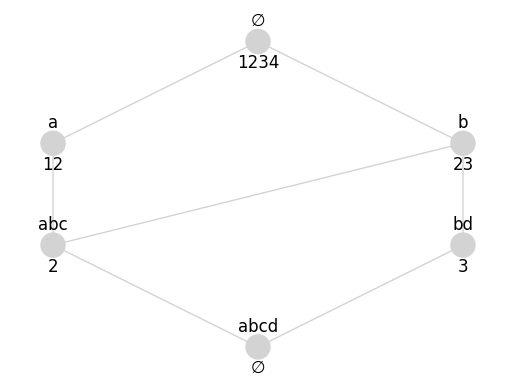

In [10]:
def node_label_func(el_i, intents_, extents_):
  intent = intents_[el_i]
  intent = intent if intent != '' else r'$\emptyset$'

  extent = extents_[el_i]
  extent = extent if extent != '' else r'$\emptyset$'
  return f"{intent}\n\n{extent}"


fig, ax = plt.subplots()

viz = LineVizNx()
viz.draw_poset(
  intents, ax=ax,
  node_label_func=lambda el_i, poset: node_label_func(el_i, intents, extents)
)

plt.show()

Let us compute the stability of top concept $(\{1, 2, 3, 4\}, \emptyset)$.
1. First, we should construct all possible subsets $C$ of extent $A = \{1, 2, 3, 4\}$,  
2. Second, for every subextent $C \subseteq A$ we should compute its description $C'$,
3. Finally, we count the number of description $C'$ equal to description $B = \emptyset$ and divide this number by $2^{|A|} = 2^4 = 16$.

In [11]:
compute_df = pd.DataFrame()
compute_df['C'] = list(powerset('1234'))
# the following works since extents (i) make a lattice and (ii) are ordered by increasing cardinality
compute_df["C'"] = [intents[max([i for i, extent in enumerate(extents) if set(C) <= set(extent)])]
                    for C in compute_df['C']]
compute_df["C'=B"] = compute_df["C'"] == ''
print(compute_df)
print('Stability( 1234, ∅ ) = ', compute_df["C'=B"].sum(), '/', len(compute_df))

               C    C'   C'=B
0             ()  abcd  False
1           (1,)     a  False
2           (2,)   abc  False
3           (3,)    bd  False
4           (4,)         True
5         (1, 2)     a  False
6         (1, 3)         True
7         (1, 4)         True
8         (2, 3)     b  False
9         (2, 4)         True
10        (3, 4)         True
11     (1, 2, 3)         True
12     (1, 2, 4)         True
13     (1, 3, 4)         True
14     (2, 3, 4)         True
15  (1, 2, 3, 4)         True
Stability( 1234, ∅ ) =  10 / 16


**Practical problems of Stability index**

The problem with the stability index is that it takes _exponential_ time to compute the stability for a single concept. This is due to iterating over all subsets of objects $A$ of the concept $(A, B)$.

Also, the values of concept stability for big contexts often lie very close to 1. So that one concept can have the stability index of 0.9999999 and another would have the stability of 0.99999997. These values are hard to process both for humans and the machines.

### Approximation of concept stability

**Logarithmic stability** solves the problem of stabilities being close to 1:
$$\mathrm{lstab}\big( (A, B) \big) = - \log_2\Big(1 - \mathrm{stab}\big((A, B)\big) \Big).$$

But log-stability is still exponential to compute.

**Delta measure** solves the computation problem of concept stability.

Let us say that $L$ is a concept lattice, and $\mathrm{DD}\big( (A,B) \big) \subseteq L$ are the direct descendants of concept $(A,B)$ from the lattice $L$. That is, $\mathrm{DD}\big( (A,B) \big)$ are the minimal concepts that are bigger than $(A,B)$:

$$\begin{aligned}
\mathrm{DD}\big( (A,B) \big) = \{(C,D) \in L \mid &(A,B) < (C,D) \text{ and } \\ &\nexists (E,F) \in L \text{ s.t. } (A,B) < (E,F) < (C,D) \}
\end{aligned}$$

Then, delta measure is defined as the difference in the support of concept $(A,B)$ and the maximal support among its direct descendants.

$$\Delta \big( (A, B) \big) = |A| - \max_{(C, D) \in \mathrm{DD}((A,B))} |C|$$

_**Example**_

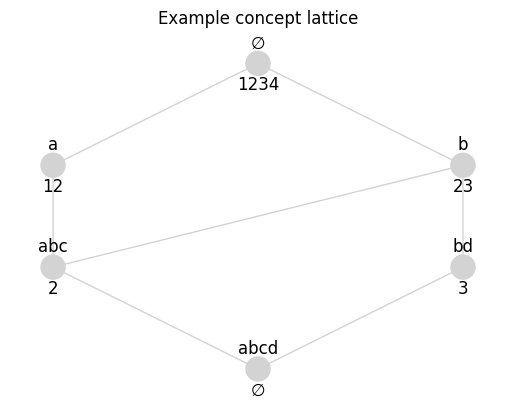

In [12]:
def node_label_func(el_i, intents_, extents_):
  intent = intents_[el_i]
  intent = intent if intent != '' else r'$\emptyset$'

  extent = extents_[el_i]
  extent = extent if extent != '' else r'$\emptyset$'
  return f"{intent}\n\n{extent}"


fig, ax = plt.subplots()

viz = LineVizNx()
viz.draw_poset(
  intents, ax=ax,
  node_label_func=lambda el_i, poset: node_label_func(el_i, intents, extents)
)
plt.title('Example concept lattice')

plt.show()

Let us compute the Δ-measure of top concept $(\{1, 2, 3, 4\}, \emptyset)$.
1. First, we should find the extents of concept's direct descendants in the lattice;
2. Second, we find the maximal support among concept's descendants;
3. Finally, we substract the maximal descendants support from the support of the concept.

In [13]:
intent = ''
index = intents.index(intent)

compute_df = pd.DataFrame()
compute_df['direct_descendant index'] = list(intents.children(index))
compute_df['direct_descendant extent'] = [extents[i] for i in compute_df['direct_descendant index']]
compute_df['support'] = [len(extent) for extent in compute_df['direct_descendant extent']]
compute_df = compute_df.set_index('direct_descendant index')
print(compute_df)
print('Delta-measure = ', len(extents[index]), '-', compute_df['support'].max(), '=', len(extents[index])-compute_df['support'].max())

                        direct_descendant extent  support
direct_descendant index                                  
1                                             12        2
2                                             23        2
Delta-measure =  4 - 2 = 2


**Delta-measure and Stability**

It is proven that Delta-measure can serve as a bound on the logarithmic stability of a concept. Specifically, for a formal context $(G, M, I)$ and a concept $(A,B)$ from this context:

$$\Delta\big( (A, B) \big) - \log_2(|M|) \leq lstab \big( (A, B) \big) \leq \Delta\big( (A, B) \big).$$

So, Delta-measure (computable in linear) can be used as an approximation of the logarithmic stability $lstab$, and, therefore, the stability $stab$ of a concept (computable in exponential time).

In our example:
* $stab\big( (A,B) \big) = \frac{10}{16}$, $lstab\big( (A,B) \big) = -\log_2\big(1- stab\big((A,B) \big) \big) ≈ 1.42$,
* $\Delta\big( (A,B) \big) = 2$,
* $|M| = 4, \log_2(|M|) = 2$,
so:

$$\begin{align}
\Delta\big( (A, B) \big) - \log_2(|M|) &\leq & lstab \big( (A, B) \big) &\leq &
\Delta\big( (A, B) \big) \\
2- 2 &\leq & 1.42 &\leq& 2
\end{align}$$

## 1.3 Mining stable formal concepts

So, if we computed the concept lattice and found out it contains a thousands of concepts, we can simply look at 10, 20, 30 concepts with the highest Delta-measure values.

But what if the original data is very complex and its lattice contains a trilliard of concepts? Then, we assume that many of such concepts have low Delta-measure values. So we want to find the concepts with highest Delta-measure values without computing all the concepts.

**Sofia** algorithm (also Σοφια) was created to find the concepts with the highest Delta-measure value.

Note that it does not find the concepts with the _maximal_ Delta-measure values It rather filters out the concepts that has definitely _low_ Delta-measure values. So the algorithm output the concepts with high Delta-measure values, but not with the _highest_ values.

The algorithm was published is presented in paper [1]. The functioning of the algorithm is quite complex. So we do not provide it here. However, we mention the input and the output of the algorithm (according to `caspailleur` implementation).

___
 _[1] Buzmakov, A., Kuznetsov, S. O., & Napoli, A. (2015, August). Fast generation of best interval patterns for nonmonotonic constraints. In Joint European Conference on Machine Learning and Knowledge Discovery in Databases (pp. 157-172). Cham: Springer International Publishing._

**_Input of Sofia algorithm_**

The function `csp.mine_equivalence_classes.list_stable_extents_via_sofia` takes as input an iterator over extents (in the form of bitarrays) (parameter `attribute_extents`) and the maximal required size of the output (parameter `n_stable_extents`).

Two parameters `use_tqdm` and `n_attributes` allow for drawing `tqdm` barplot.

**_Output of Sofia algorithm_**

The algorithm outputs a set of stable extents (no more than `n_stable_extents`). Then, given the original data, one can find the stable intents and order them into a lattice.

**_The pipeline_**

Note that the algorithm estimates the stability of the concepts based on a lattice of more than `n_stable_extents` concepts. So, the higher is the number `n_stable_extents` the more reliable are the results. And, contrary, if `n_stable_extents` number is low, then results of the algorithm are unreliable.  

So, the full pipeline of data analysis would be:
$$\text{data} \overset{\text{Sofia}}{\longrightarrow} \text{thousands of stable concepts} \overset{\text{Data Analysis}}{\longrightarrow} \text{dozens of final interesting concepts}$$


Let us compute the stable extents via Sofia

In [14]:
attr_extents = csp.np2bas(df.values.T)

stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_sofia(
    attr_extents, n_stable_extents=1000,
    use_tqdm=True, n_attributes=len(attr_extents)
)
stable_extents = sorted(stable_extents, key=lambda ext: ext.count())
print(len(stable_extents))

  0%|          | 0/67 [00:00<?, ?it/s]

827


Compute the stable intents based on the given stable extents

In [15]:
stable_extents_isets = list(csp.base_functions.bas2isets(stable_extents))
attr_extents_isets = list(csp.base_functions.bas2isets(attr_extents))

stable_intents = [list(csp.base_functions.intention(extent, attr_extents_isets))
                  for extent in stable_extents_isets]

Put everything into a Pandas DataFrame for manual analysis

In [16]:
patterns_df = pd.DataFrame()
patterns_df['extents'] = stable_extents_isets
patterns_df['intents'] = stable_intents
patterns_df['intents_verb'] = [list(df.columns[intent]) for intent in stable_intents]
patterns_df['support'] = [len(extent) for extent in stable_extents_isets]
patterns_df['delta_measure'] = list(csp.indices.delta_stability_index(stable_extents))

patterns_df.head()

,extents,intents,intents_verb,support,delta_measure
0,"(267, 115, 15)","[13, 15, 16, 40, 58, 62]","[clouds, cumulus, deciduous, ocean, tree, waves]",3,3
1,"(33, 27, 147)","[13, 15, 39, 40, 62]","[clouds, cumulus, night, ocean, waves]",3,3
2,"(250, 227, 261)","[16, 25, 48, 58, 59]","[deciduous, fog, river, tree, trees]",3,3
3,"(250, 180, 338)","[16, 25, 26, 41, 58, 59]","[deciduous, fog, framed, oval_frame, tree, trees]",3,3
4,"(186, 330, 157)","[8, 13, 14, 32, 37, 38, 52, 55, 58, 59, 65]","[cabin, clouds, conifer, lake, mountain, mount...",3,3


## 1.4 Select the most interesting concepts

From this step, analysis of concepts can be done via typical data analysis. And you are free to choose the interestingness and the amount of interesting patterns depending on your specific task.

For example, you can say that the concept is interesting if its support is higher than $x$ and its delta measure is higher than $y$.

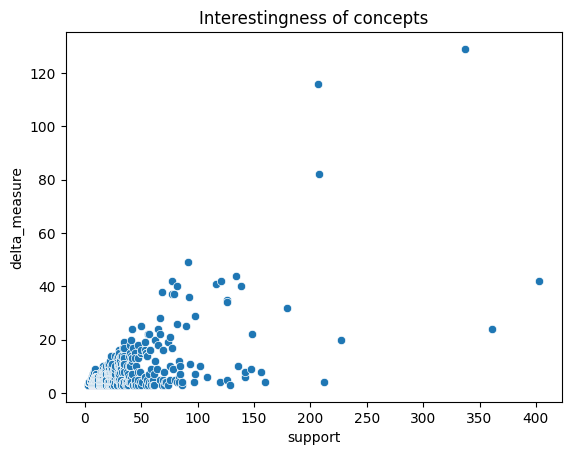

In [17]:
sns.scatterplot(x=patterns_df['support'], y=patterns_df['delta_measure'])
plt.title('Interestingness of concepts')
plt.show()

In [18]:
patterns_df[(patterns_df['support']>50)&(patterns_df['delta_measure']>10)].head(10)

,extents,intents,intents_verb,support,delta_measure
731,"(3, 131, 133, 135, 136, 137, 391, 16, 144, 18,...","[7, 13, 58, 59]","[bushes, clouds, tree, trees]",53,16
733,"(128, 1, 385, 3, 134, 262, 137, 11, 269, 16, 1...","[13, 14, 37, 52, 58, 59]","[clouds, conifer, mountain, snowy_mountain, tr...",53,19
735,"(3, 259, 387, 7, 136, 9, 137, 13, 16, 17, 20, ...","[7, 32, 58, 59]","[bushes, lake, tree, trees]",54,15
736,"(3, 259, 387, 389, 7, 9, 137, 395, 12, 13, 16,...","[7, 14, 37, 58, 59]","[bushes, conifer, mountain, tree, trees]",54,15
739,"(256, 129, 2, 131, 384, 5, 391, 264, 266, 16, ...","[8, 55, 58, 59]","[cabin, structure, tree, trees]",55,14
740,"(130, 134, 395, 12, 13, 398, 271, 400, 145, 40...","[27, 37, 58, 59]","[grass, mountain, tree, trees]",55,14
742,"(128, 385, 259, 260, 5, 262, 387, 11, 269, 398...","[14, 37, 38, 52, 58, 59]","[conifer, mountain, mountains, snowy_mountain,...",56,22
743,"(129, 4, 389, 134, 262, 136, 392, 266, 393, 14...","[49, 58, 59]","[rocks, tree, trees]",57,22
746,"(0, 130, 134, 392, 395, 142, 18, 276, 149, 22,...","[27, 48, 58, 59]","[grass, river, tree, trees]",58,16
747,"(384, 129, 3, 136, 137, 11, 140, 141, 16, 145,...","[13, 32, 58, 59]","[clouds, lake, tree, trees]",58,16


Or you can merge support and delta-measure by multiplying them into a new interestingness measure

In [19]:
patterns_df['interestingness'] = patterns_df['support'] * patterns_df['delta_measure']

## 1.5 Visualize the most interesting concepts

Whatever interestingness measure you chose, you can select the patterns you consider most important and you can put them into a line diagram

In [20]:
best_patterns = patterns_df.sort_values('interestingness', ascending=False).head(20).reset_index(drop=True)
best_patterns

,extents,intents,intents_verb,support,delta_measure,interestingness
0,"(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[58, 59]","[tree, trees]",337,129,43473
1,"(0, 4, 6, 9, 10, 12, 13, 15, 16, 17, 18, 21, 2...","[16, 58, 59]","[deciduous, tree, trees]",207,116,24012
2,"(1, 2, 3, 5, 7, 9, 11, 12, 13, 14, 16, 19, 20,...","[14, 58, 59]","[conifer, tree, trees]",208,82,17056
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],[],403,42,16926
4,"(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...",[58],[tree],361,24,8664
5,"(3, 5, 6, 7, 9, 10, 11, 13, 14, 16, 17, 19, 20...","[32, 58, 59]","[lake, tree, trees]",134,44,5896
6,"(1, 3, 8, 11, 15, 16, 18, 19, 20, 23, 25, 27, ...",[13],[clouds],179,32,5728
7,"(1, 3, 11, 15, 16, 18, 19, 20, 23, 25, 27, 30,...","[13, 58, 59]","[clouds, tree, trees]",138,40,5520
8,"(0, 4, 18, 22, 23, 28, 34, 48, 58, 59, 64, 65,...","[48, 58, 59]","[river, tree, trees]",121,42,5082
9,"(0, 3, 7, 9, 12, 13, 16, 17, 18, 20, 23, 25, 2...","[7, 58, 59]","[bushes, tree, trees]",116,41,4756


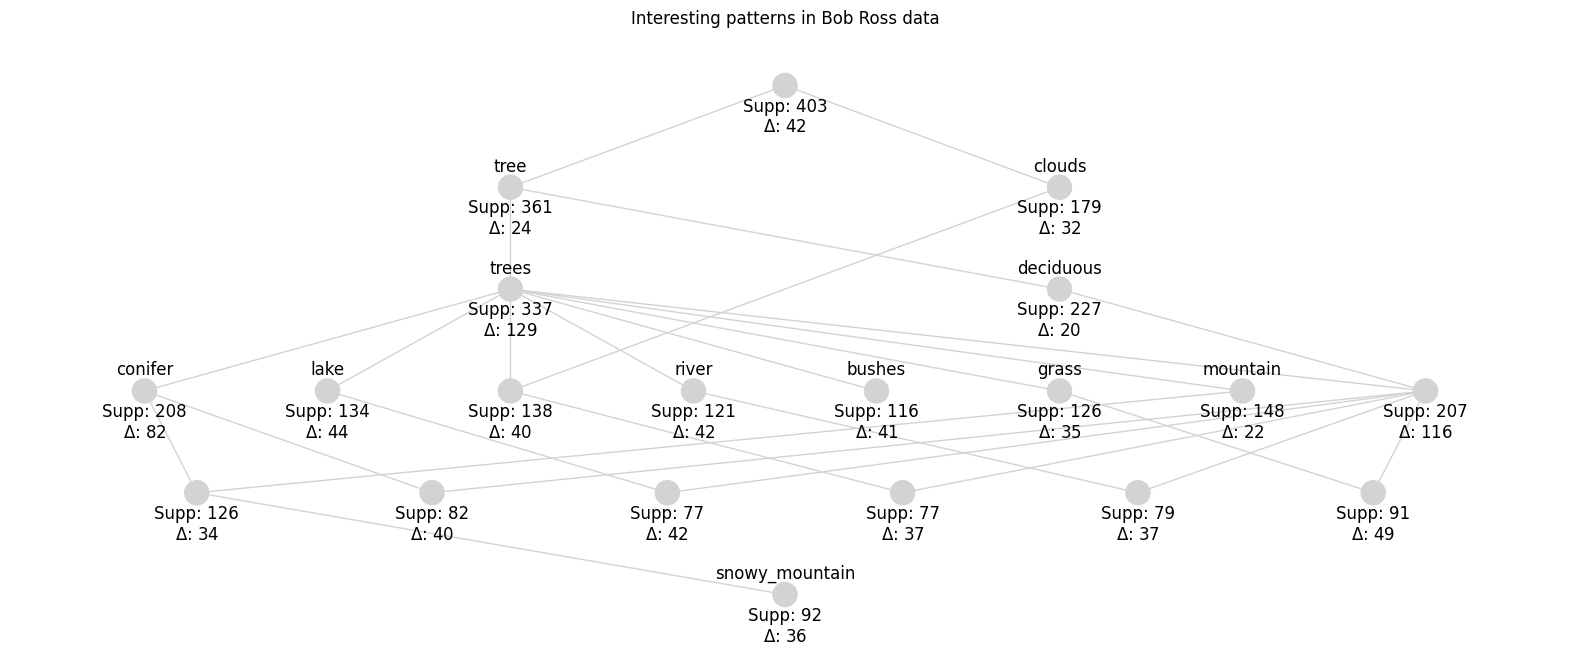

In [21]:
poset = POSet(best_patterns['extents'])

fig, ax = plt.subplots(figsize=(20,8))

node_label_func_binary = lambda el_i, P: concept_label_func(el_i, P, best_patterns, intent_to_strings_binary)
viz = LineVizNx()
viz.draw_poset(
    poset, ax=ax,
    node_label_func = node_label_func_binary
)
plt.title('Interesting patterns in Bob Ross data')
plt.show()

The first automatically created graph can look messy. So we should manually update the nodes positions.

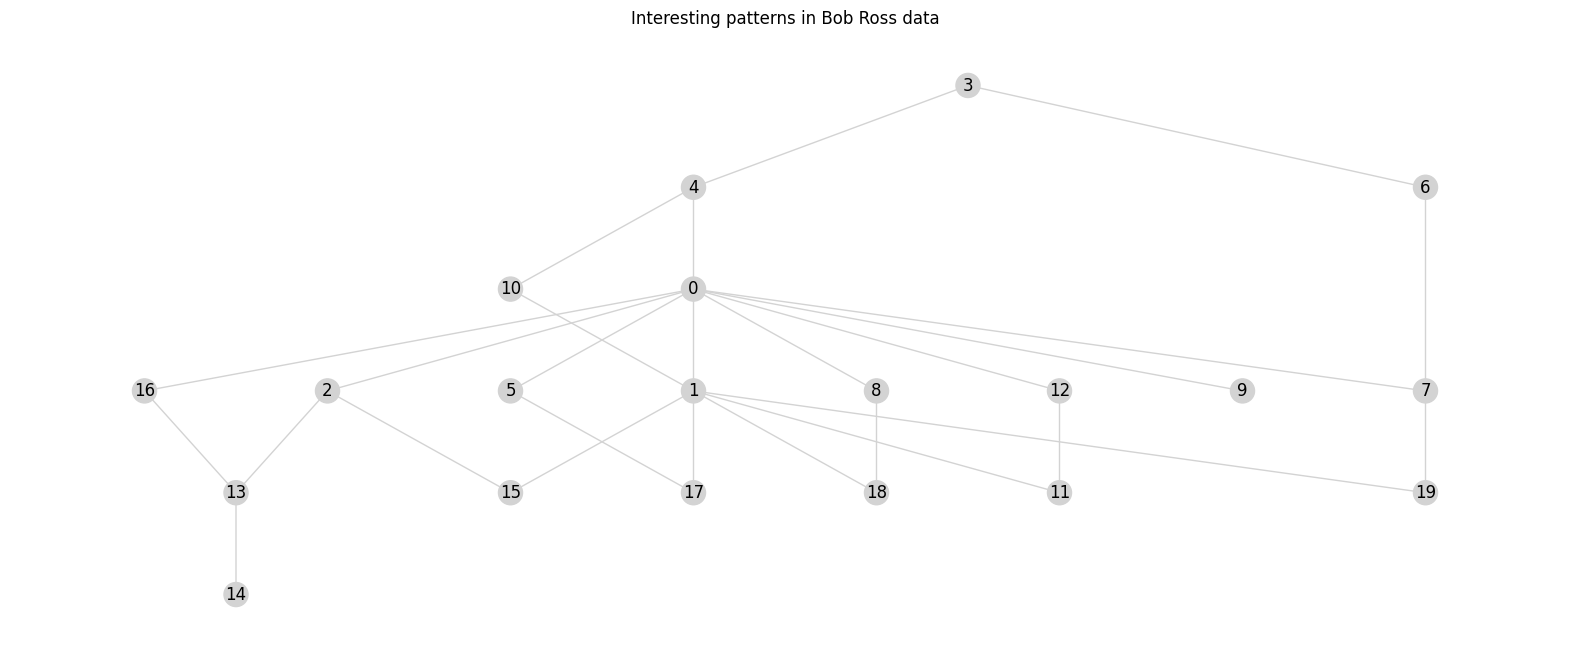

In [22]:
fig, ax = plt.subplots(figsize=(20,8))

viz = LineVizNx()


viz.init_mover_per_poset(poset)  # Initialize the nodes positions
posx = list(viz.mover.posx)
# The position adjustments below are chosen manually
dx = posx[5]-posx[2]
posx[16] = posx[2] - dx
posx[13] = (posx[16]+posx[2])/2
posx[7] = posx[12] + dx
posx[5] = posx[2] + dx
posx[1] = posx[8] - dx
posx[9], posx[12] = posx[12], posx[9]
for i, align_i in [(14, 13), (15, 5), (17, 1), (10, 5), (18, 8), (11, 12), (19, 7), (6, 7)]:
  posx[i] = posx[align_i]
viz.mover.posx = posx  # Save the adjusted nodes positions

viz.draw_poset(
    poset, ax=ax,
    flg_node_indices=True,  # Visualize the nodes indices, so that it would be easier to access each specific node
)
plt.title('Interesting patterns in Bob Ross data')
plt.show()

Now we can draw the concepts with better positioning.

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


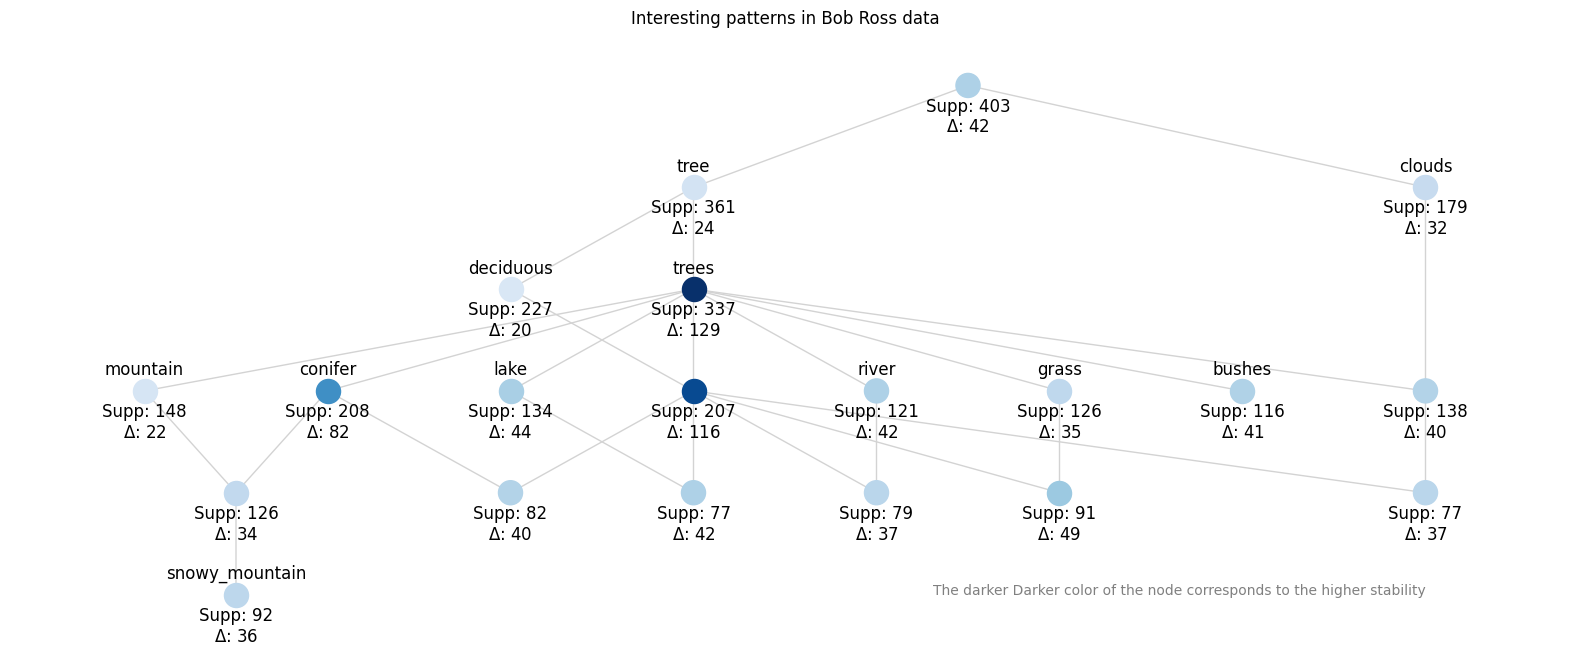

In [23]:
fig, ax = plt.subplots(figsize=(20,8))

# We can also adjust the node colors to reflect something. For example, delta stability of concepts
cmap = plt.colormaps.get_cmap('Blues')
node_color = [cmap(delta) for delta in best_patterns['delta_measure']/best_patterns['delta_measure'].max()]
ax.text(max(viz.mover.posx), min(viz.mover.posy), 'The darker Darker color of the node corresponds to the higher stability', ha='right', color='gray')

viz.draw_poset(
    poset, ax=ax,
    node_label_func = lambda el_i, P: concept_label_func(el_i, P, best_patterns, intent_to_strings_binary),
    node_color=node_color,
)

ax.set_title('Interesting patterns in Bob Ross data')
fig.savefig('IntPatterns_Binary.pdf')
plt.show()

# Part 2. Stable tabular concepts

## 2.1 Load the data

Now let us find the stable concepts in the tabular data. For example, in the Adult dataset from UCI repository: https://archive.ics.uci.edu/dataset/2/adult

In [24]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income-per-year']
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-per-year
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


This dataset contains many objects and many complex (i.e. non-binary) attributes. So (i) it can contain billions of concepts, and (ii) it cannot be processed by the traditional (binary) FCA.

## 2.2 Introducing pattern structures

__Pattern structures__ are the extension of the classical binary FCA that allow it to work with many complex data.

In binary FCA we deal with formal context $(G, M, I)$ with objects $G$, (binary) attributes $M$, and connections between objects and attributes $I$.
With pattern structures, we work with __many-valued context__ $(G, (D, \sqcap), \delta)$ where $G$ is the set of objects, $D$ is the space of descriptions, $\sqcap: D \times D \to D$ is the operation that outputs the maximal description smaller than the two given descriptions, and $\delta: G \to D$ maps every object $g \in G$ to its description in $\delta(g) \in D$.

So we can reformulate the original definitions of the prime operations to the following:
$$A' = ⨅_{g \in A} \delta(g), \quad A \subseteq G$$
$$B' = \{g \in G \mid B \sqsubseteq \delta(g)\}, \quad B \in D$$

_In the literature, one often write $A^\diamond$ and $B^\diamond$ for pattern operations instead of $A'$ and $B'$ for binary FCA. However, in this notebook, we do not want to make this difference._

In the Adult data we face two types of columns: numerical and categorical. For the former type, we can compare any two values from the column (i.e. one can say, for example, that age 39 is less than age 50); and for the latter, we can compare _no_ two values from the column (i.e. one cannot say, for example, that occupation "Adm-clerical" is less than "Exec-managerial").

We can model the numerical columns via Interval pattern structures, and the categorical columns via SuperSet pattern structures.
Finally, we can join two pattern structures together with Cartesian pattern structure.


**_Interval pattern structure_**

With the **interval pattern structure** $(D, \sqcap)$ we say that every description $d \in D$ is the closed interval $[a, b] = d$. And meet operation $\sqcap$ outputs the smallest interval greater than the two given intervals.

For example, we can have a group of people with age range $d_1 = [30, 50]$, and the other group of people with age range $d_2 = [40, 60]$. So $d_1 \sqcap d_2$ would be their common age range $[30, 60]$.

**Important** With pattern structures we write $d_1 \sqsubseteq d_2$ when description $d_1$ is less precise than description $d_2$. So with interval pattern structures we get the following notation: $[30, 60] \sqsubseteq [40, 50]$. This seems contr-intuitive. Nevertheless, the description $[30, 60]$ is indeed less precise than $[40, 50]$. That is, there are more people with the age from 30 to 60 years old than there are people with the age from 40 to 50 years old.



**_SuperSet pattern structure_**

With the **SuperSet pattern structure** $(D, \sqcap)$ we say that every description $d \in D$ is the subset set of values $V$: $d \subseteq V$. And meet operation $\sqcap$ outputs the union between two given subsets of values.

_So the meet operation outputs a superset of two given sets. Hence, the name._

For example, we can have many native-countries $V = \{\text{USA}, \text{France}, \ldots\}$. Then description $d_1 = \{\text{USA}\}$ would represent the people from the USA, and description $d_2 = \{\text{France}\}$ would represent the people from France. In this case $d_1 \sqcap d_2$ would be the people from the USA and France: $d_1 \sqcap d_2 = \{\text{USA}\} \sqcap \{\text{France}\} = \{\text{USA}, \text{France}\}$. Again, the notation looks contr-intuitive. But it works.

**_Cartesian pattern structure_**

Interval and SuperSet pattern structure can model one column in the data (numerical and categorical respectively). But the data usually have many columns. In this case, we can unite many independent pattern structures under one **Cartesian pattern structure**.

Given a tuple of $n$ pattern structures $\big((D_i, \sqcap_i)\big)_{i=1}^n$, Cartesian pattern structure $(D_\times, \sqcap_\times)$ is a pattern structure, s.t.:
$$D_\times = D_1 \times D_2 \times \ldots \times D_n, \quad d = (d^1, d^2, \ldots, d^n), d \in D_\times$$
$$d_1 \sqcap_\times d_2 = (d_1^1 \sqcap_1 d_2^1,\ d_1^2 \sqcap_2 d_2^2,\ \ldots,\ d_1^n \sqcap_n d_2^n)$$

Let us see these three pattern structures in practice

In [25]:
dtypes = df.dtypes.values
pstructures = [PS.SuperSetPS() if dtype == 'O' else PS.IntervalPS() for dtype in df.dtypes.values]  # define pattern structures per column
ps = PS.CartesianPS(basic_structures=pstructures)  # put all the column pattern structures into one cartesian pattern structure

data = list(ps.preprocess_data(df.values))  # small data preprocessing. For example, transform the age 39 to the interval [39.0, 39.0]

Visualize the first two objects with a DataFrame

In [26]:
pd.DataFrame(data[:2], columns=df.columns)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-per-year
0,"(39.0, 39.0)",( State-gov),"(77516.0, 77516.0)",( Bachelors),"(13.0, 13.0)",( Never-married),( Adm-clerical),( Not-in-family),( White),( Male),"(2174.0, 2174.0)","(0.0, 0.0)","(40.0, 40.0)",( United-States),( <=50K)
1,"(50.0, 50.0)",( Self-emp-not-inc),"(83311.0, 83311.0)",( Bachelors),"(13.0, 13.0)",( Married-civ-spouse),( Exec-managerial),( Husband),( White),( Male),"(0.0, 0.0)","(0.0, 0.0)","(13.0, 13.0)",( United-States),( <=50K)


Intent of the first two objects would be the most precise description that covers both objects

In [27]:
intent = ps.intent(data[:2])
pd.DataFrame([intent], columns=df.columns)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-per-year
0,"(39.0, 50.0)","( State-gov, Self-emp-not-inc)","(77516.0, 83311.0)",( Bachelors),"(13.0, 13.0)","( Married-civ-spouse, Never-married)","( Adm-clerical, Exec-managerial)","( Husband, Not-in-family)",( White),( Male),"(0.0, 2174.0)","(0.0, 0.0)","(13.0, 40.0)",( United-States),( <=50K)


The age of the first person is $39$, and the age of the second person is $50$. Thus, their most precise common age would be $[39, 50]$.

Analogously with the marital status: the first person was never married, the second one is married-civ-spouse. So their most precise common description is $\{\text{Never-married}, \text{Married-civ-spouse}\}$, meaning that any of these two people is never-married or married-civ-spouse.

## 2.3 Mining stable tabular concepts

Pattern structures allow to work with the data without binarizing it. However, Sofia algorithm still takes the binary columns as input. So, `paspailleur` package provides built-in functions to binarize the complex data with pattern structures.

Currently, every numerical column with $n$ unique values is binarized into $2n$ columns, and every categorical column with $n$ unique values is binarized into $2^n$ columns.

The following code shows the 1001st binary column generated by Cartesian pattern structure for Adult dataset.

In [28]:
bin_attrs_iterator = ps.iter_bin_attributes(data)
for i in range(1000):
    next(bin_attrs_iterator)

bin_attr, extent = next(bin_attrs_iterator)
print(f'Binary attribute: {bin_attr}')
print(f'Extent: {extent}')

Binary attribute: (2, (29361.0, 1484705.0))
Extent: frozenbitarray('11111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111110111111111111111111111111111111111111111110111111111111111111111111110111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111110111111101110111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111

Binary attribute $(2, (29361.0, 1484705.0))$ is True whenever the value of the column with index $2$ lies within the interval $[29361, 1484705]$.

However, if we pass these binary columns into the Sofia algorithm it will work for a very long time. The reason for this is that the dataset is binarized into 4 trillions of binary columns:

In [29]:
f"{ps.n_bin_attributes(data):,}"

'4,398,046,654,236'

The following code computes the number of binary attributes corresponding to each of the columns:

In [30]:
n_bin_attrs_per_column = [base_ps.n_bin_attributes([row[i] for row in data])
                          for i, base_ps in enumerate(ps.basic_structures)]
pd.Series(n_bin_attrs_per_column, index=df.columns).sort_values(ascending=False)

native-country     4398046511104
education                  65536
fnlwgt                     43296
occupation                 32768
workclass                    512
capital-gain                 238
hours-per-week               188
capital-loss                 184
age                          146
marital-status               128
relationship                  64
education-num                 32
race                          32
sex                            4
income-per-year                4
dtype: int64

So, for some reason, the 'native-country' column is binarized into 4 trillions of columns. Let us investigate what has happend.

In [31]:
print(df['native-country'].nunique())
(df['native-country'].value_counts()/len(df)*100).round(1).head(10)

42


 United-States    89.6
 Mexico            2.0
 ?                 1.8
 Philippines       0.6
 Germany           0.4
 Canada            0.4
 Puerto-Rico       0.4
 El-Salvador       0.3
 India             0.3
 Cuba              0.3
Name: native-country, dtype: float64

There are $42$ unique native countries in the dataset. Therefore, `paspailleur` creates $2^{42} = 4398046511104$ binary attributes.

However, most of these countries are very rare (w.r.t. the dataset). For example, there are 89.6% of people from the United States, only 2% of people are from Mexico, and even fewer people are from the other countries.

So let us replace every rare categorical value in the dataset with the value 'other'. And let us set the "rareness" threshold to 10%.

In [32]:
MIN_SUPP = 0.1
df_groupped = df.copy()

for f, dtype in df.dtypes.items():
    if dtype != 'O':
        continue

    values_rate = df[f].value_counts()/len(df)
    df_groupped[f] = [x if values_rate[x]>=MIN_SUPP else 'others' for x in df[f]]

data_groupped = list(ps.preprocess_data(df_groupped.values))
f"# bin attributes: {ps.n_bin_attributes(data_groupped):,}"

'# bin attributes: 44,296'

In [33]:
n_bin_attrs_per_column = [base_ps.n_bin_attributes([row[i] for row in data_groupped])
                          for i, base_ps in enumerate(ps.basic_structures)]
pd.Series(n_bin_attrs_per_column, df.columns).sort_values(ascending=False)

fnlwgt             43296
capital-gain         238
hours-per-week       188
capital-loss         184
age                  146
occupation           128
education-num         32
relationship          32
education             16
marital-status        16
workclass              4
race                   4
sex                    4
native-country         4
income-per-year        4
dtype: int64

Now we would be able to run the computations much faster.
However, we still have a lot of binary columns generated by "fnlwgt" column.

The column "fnlwgt" (short for "final weight") is numerical and reflects some social status index. So the people with the high "fnlwgt" are "successful" and the people with the low "fnlwgt" are not that much successful.

Let us convert this column to percentages and round up the new values by two symbols after the dot.

In [34]:
df_groupped['fnlwgt'] = df_groupped['fnlwgt']/df_groupped['fnlwgt'].max()
df_groupped['fnlwgt'] = df_groupped['fnlwgt'].round(2)

data_groupped = list(ps.preprocess_data(df_groupped.values))
f"# bin attributes: {ps.n_bin_attributes(data_groupped):,}"

'# bin attributes: 1,150'

Now, if we binarize the data, we would only have a thousand of binary columns. So we are ready to run the Sofia algorithm.

In [35]:
attr_extents = (ext for descr, ext in ps.iter_bin_attributes(data_groupped))

stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_sofia(
    attr_extents, n_stable_extents=1000,
    use_tqdm=True, n_attributes=ps.n_bin_attributes(data_groupped)
)
stable_extents = sorted(stable_extents, key=lambda ext: ext.count())
print(len(stable_extents))

  0%|          | 0/1150 [00:00<?, ?it/s]

1000


And now we can put all the patterns in the table.

In [36]:
stable_extents_isets = list(csp.base_functions.bas2isets(stable_extents))
stable_intents = [ps.intent(data_groupped, extent) for extent in tqdm(stable_extents_isets)]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [37]:
patterns_df = pd.DataFrame()
patterns_df['extents'] = stable_extents_isets
patterns_df['intents'] = stable_intents
patterns_df['intents_verb'] = [{df.columns[m]: value for m, value in enumerate(intent)} for intent in stable_intents]
patterns_df['support'] = [len(extent) for extent in stable_extents_isets]
patterns_df['delta_measure'] = list(csp.indices.delta_stability_index(stable_extents))

In [38]:
patterns_df = patterns_df.sort_values(['support', 'delta_measure'], ascending=False)
patterns_df[['intents_verb', 'support', 'delta_measure']].head(5)

,intents_verb,support,delta_measure
999,"{'age': (19.0, 67.0), 'workclass': (' Private'...",17999,1516
998,"{'age': (19.0, 76.0), 'workclass': (' Private'...",16764,1349
997,"{'age': (19.0, 67.0), 'workclass': (' Private'...",16483,1079
996,"{'age': (19.0, 67.0), 'workclass': (' Private'...",16396,1375
995,"{'age': (19.0, 67.0), 'workclass': (' Private'...",16378,1482


Note that the process of finding stable tabular concepts is very similar to the process of finding stable formal concepts. The only difference is that now we should define the pattern structure for each column in the table, and we should do some data-specific simplication of the data in order to make the data processable.

_By the way, some state-of-the-art machine learning packages also simplify the data in order to make it processable. For example, in CatBoost this process it called "quantization"._

## 2.4 Select the most interesting concepts

We can select the interesting tabular concepts the same way we selected the interesting formal concepts.

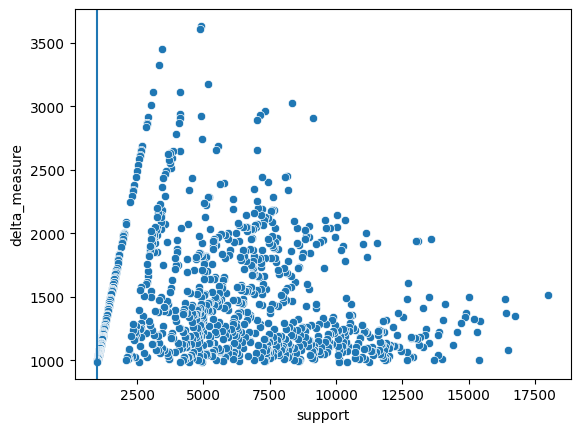

In [39]:
sns.scatterplot(x=patterns_df['support'], y=patterns_df['delta_measure'])
plt.axvline(1000)

In [40]:
patterns_df['interestingness'] = patterns_df['support'] * patterns_df['delta_measure']

## 2.5 Visualize the most interesting concepts

And now, again, we can visualize the most interesting concepts with a line diagram.

In [41]:
best_patterns = patterns_df.sort_values('interestingness', ascending=False).head(7).reset_index(drop=True)
best_patterns.head()

,extents,intents,intents_verb,support,delta_measure,interestingness
0,"(2, 4, 5, 7, 11, 13, 14, 16, 17, 19, 24, 25, 2...","((19.0, 67.0), ( Private, others), (0.03, 0.7)...","{'age': (19.0, 67.0), 'workclass': (' Private'...",17999,1516,27286484
1,"(2, 7, 13, 14, 17, 19, 24, 25, 26, 27, 29, 30,...","((19.0, 67.0), ( Private, others), (0.03, 0.7)...","{'age': (19.0, 67.0), 'workclass': (' Private'...",13582,1953,26525646
2,"(2, 5, 16, 17, 24, 26, 29, 33, 36, 39, 41, 43,...","((19.0, 67.0), ( Private, others), (0.03, 0.7)...","{'age': (19.0, 67.0), 'workclass': (' Private'...",9121,2908,26523868
3,"(2, 11, 13, 14, 17, 24, 25, 26, 27, 29, 30, 31...","((19.0, 67.0), ( Private, others), (0.03, 0.7)...","{'age': (19.0, 67.0), 'workclass': (' Private'...",13103,1936,25367408
4,"(2, 7, 11, 13, 17, 19, 24, 25, 27, 30, 31, 33,...","((19.0, 67.0), ( Private, others), (0.03, 0.7)...","{'age': (19.0, 67.0), 'workclass': (' Private'...",13009,1940,25237460


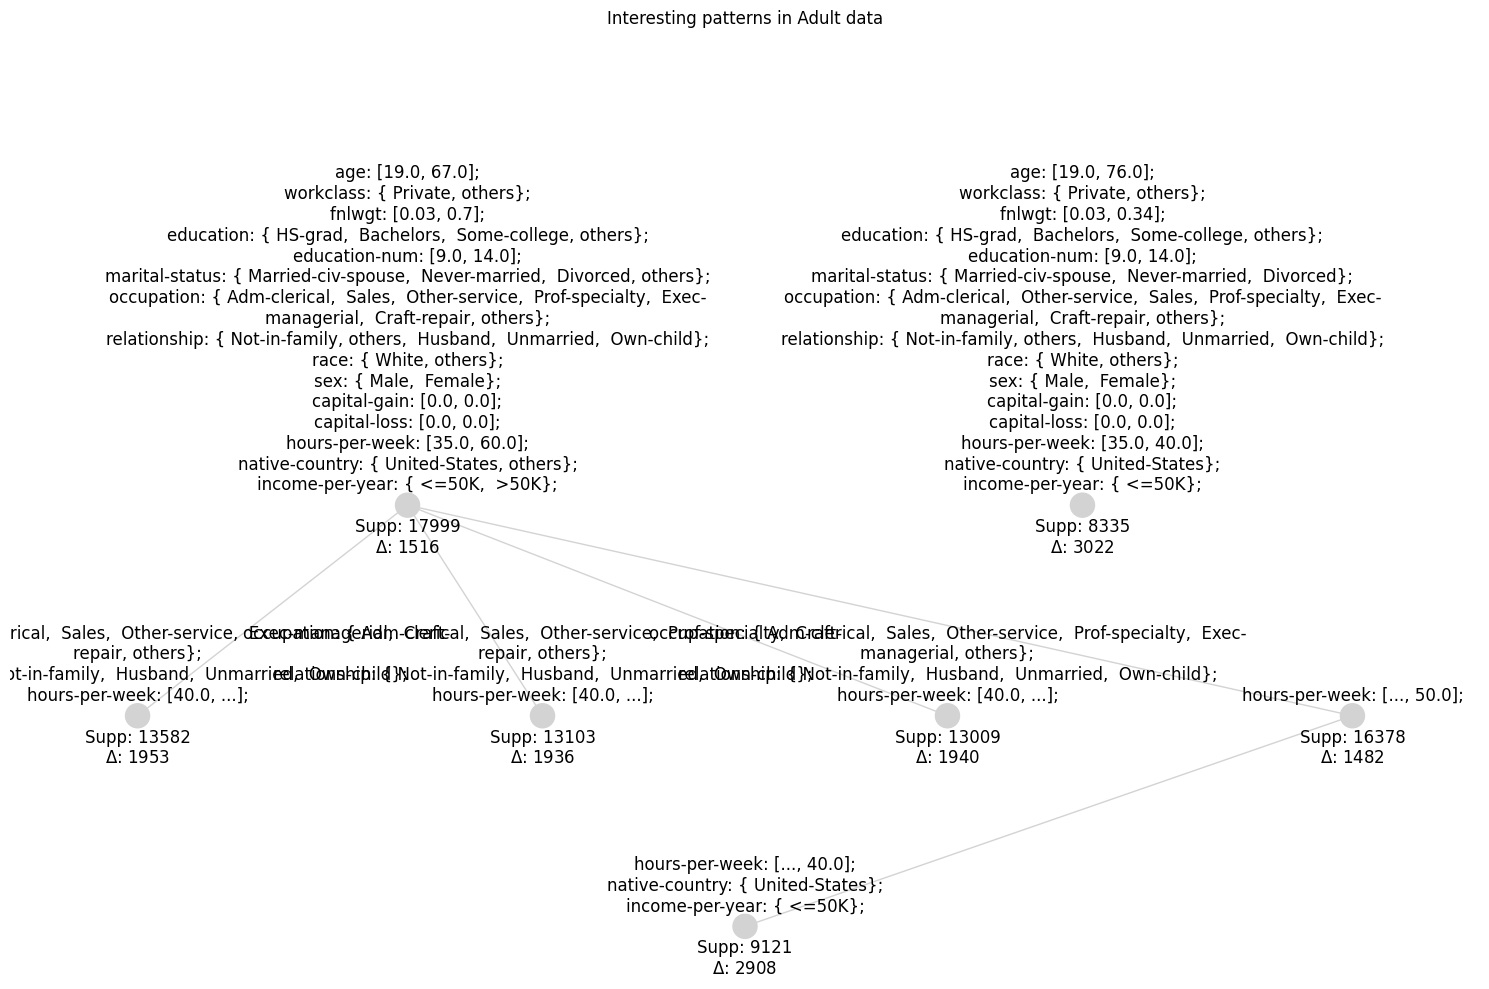

In [42]:
poset = POSet(best_patterns['extents'])

fig, ax = plt.subplots(figsize=(15,10))

viz = LineVizNx()

# Adapt the general "concept_label_func" to the specific given data and the specific given pattern structure
intent_to_strings_adult = lambda intent, parents_intents, reduce_intents: intent_to_strings_tabular(intent, parents_intents, ps, list(df.columns), reduce_intents)
node_label_func_adult = lambda el_i, P: concept_label_func(
    el_i, P, best_patterns,
    intent_to_strings_func = intent_to_strings_adult,
)
viz.draw_poset(
    poset, ax=ax,
    node_label_func = node_label_func_adult
)
plt.title('Interesting patterns in Adult data')
plt.ylim(-0.5, 2.5)
plt.tight_layout()
plt.subplots_adjust()
plt.show()

And again, the first visualization looks very messy. This is due to the fact that the original data contains 15 columns, so every closed description would contain an information about each of the 15 columns. And it takes a lot of space to write all these closed descriptions.

Note that the diagram above does not contain the top description, that is a description that would cover all the other descriptions. So let us add this decsription manually.

In [43]:
best_patterns_upd = best_patterns.copy()

# Find the extent that would include all the objects mentioned on the diagram above
new_extent = set()
for extent in best_patterns['extents']:
  new_extent |= extent
new_intent = ps.intent(data_groupped, new_extent)
new_extent = frozenset(ps.extent(data_groupped, new_intent))  # Make sure, that "new_extent" contains _all_ the objects with the "new_intent" description
best_patterns_upd.loc[len(best_patterns_upd)] = {'extents': new_extent, 'intents': new_intent, 'support': len(new_extent),
                                                 'intents_verb': {df.columns[m]: pattern for m, pattern in enumerate(new_intent)} }

# Also, note that the previous minimal common description covers all the objects from stable concepts, but not all the objects from the dataset
# So we can add _the most general_ description to the diagram. Or, if we don't want to, we don't have to add it. It all depends on the specific problem you solve
new_extent = frozenset(range(len(df)))
new_intent = ps.intent(data_groupped, new_extent)
best_patterns_upd.loc[len(best_patterns_upd)] = {'extents': new_extent, 'intents': new_intent, 'support': len(new_extent), 'intents_verb': {df.columns[m]: pattern for m, pattern in enumerate(new_intent)}}

Now we visualize the newly defined set of patterns. And we move some nodes on the diagram to make it more readable.

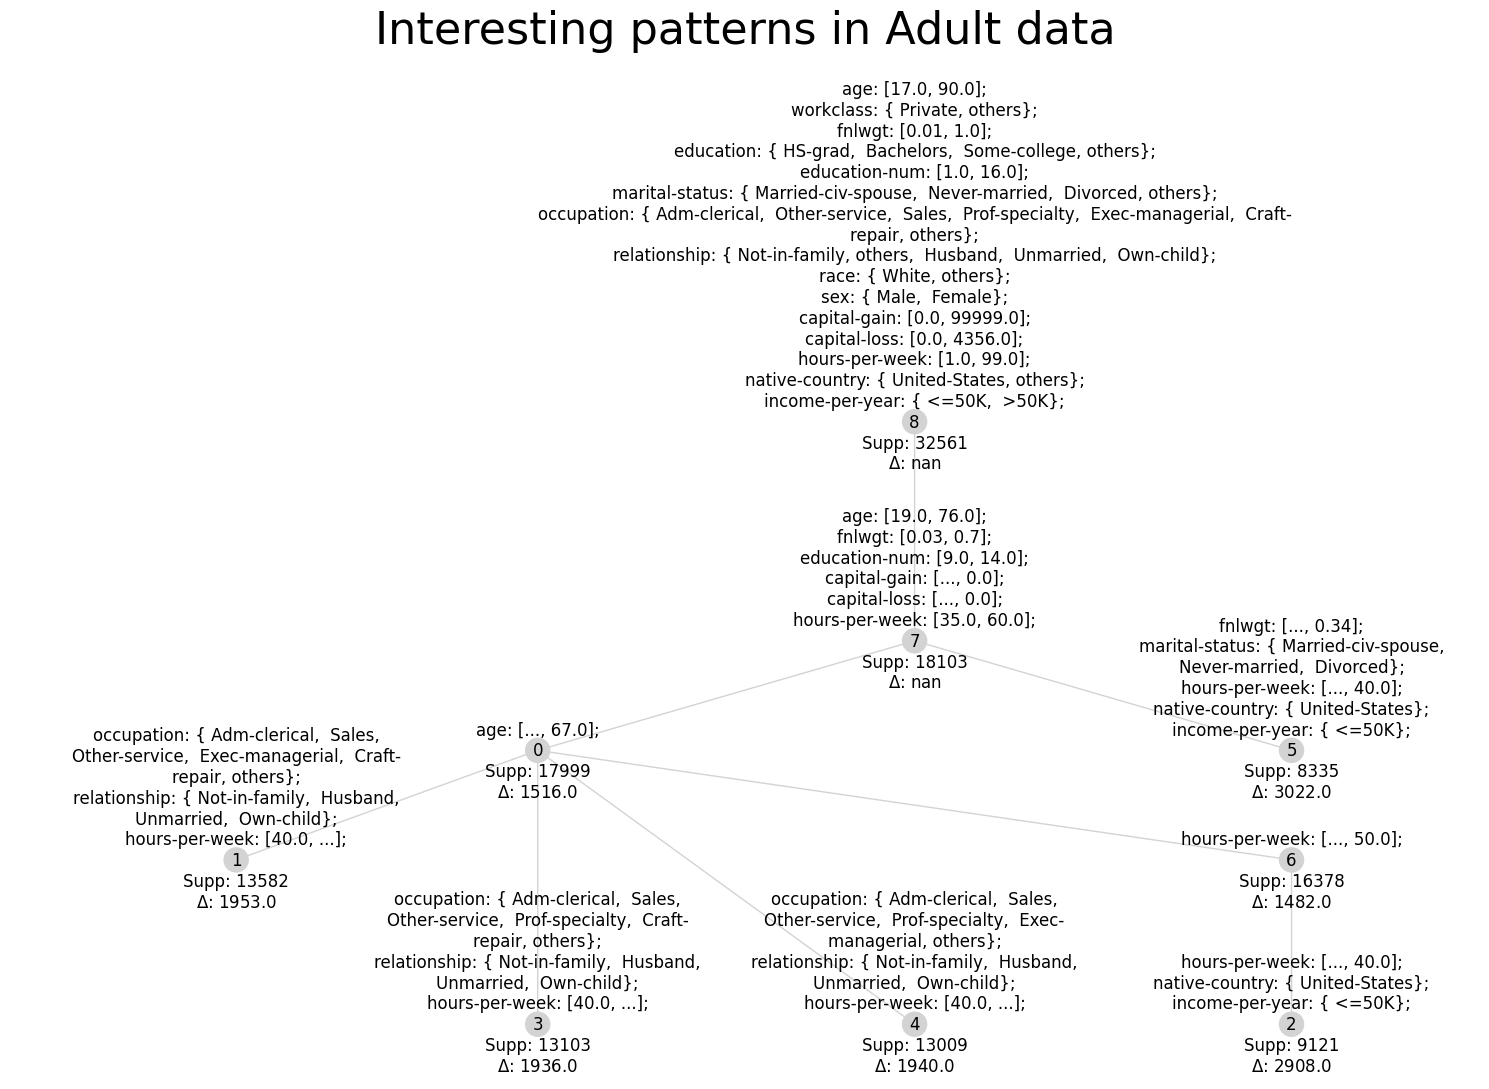

In [44]:
fig, ax = plt.subplots(figsize=(15,11))


poset = POSet(best_patterns_upd['extents'])

viz = LineVizNx()

viz.init_mover_per_poset(poset)
posx, posy = list(viz.mover.posx), list(viz.mover.posy)
dx, dy = abs(posx[1]- posx[0]), abs(posy[8] - posy[7])
posx[3], posy[3] = posx[0], posy[0] - dy*2.5
for i in [3, 4, 2]:
  posy[i] = posy[0] - dy*2.5
posx[4] = posx[7]
posx[6] = posx[5]
posx[2] = posx[5]
posy[8] += dy*1

viz.mover.pos = dict(enumerate(zip(posx, posy)))


node_label_func_adult_upd = lambda el_i, P: concept_label_func(
    el_i, P, best_patterns_upd,
    intent_to_strings_func = intent_to_strings_adult,
    n_symbols_per_line=40 if el_i not in P.tops else 100  # limit the width of label for non-top concepts
)
viz.draw_poset(
    poset, ax=ax,
    flg_node_indices=True,
    node_label_func = node_label_func_adult_upd
)
plt.title('Interesting patterns in Adult data', size=32)

#plt.grid()  # you can use the grid to find the optimal positions for xlim and ylim
for y in []:#2, 2.5, 2.75, 3]:
  plt.axhline(y)
plt.ylim(-1, 2.75)
plt.xlim(-0.8, 0.5)

plt.tight_layout()
plt.subplots_adjust()
plt.show()

And again, we can add some color to the nodes. For example, let them represent the delta-measure of the nodes. Also, since we have not computed the delta-measure for the added general concepts, we can highlight that these concepts were artificially added to make the diagram readable.

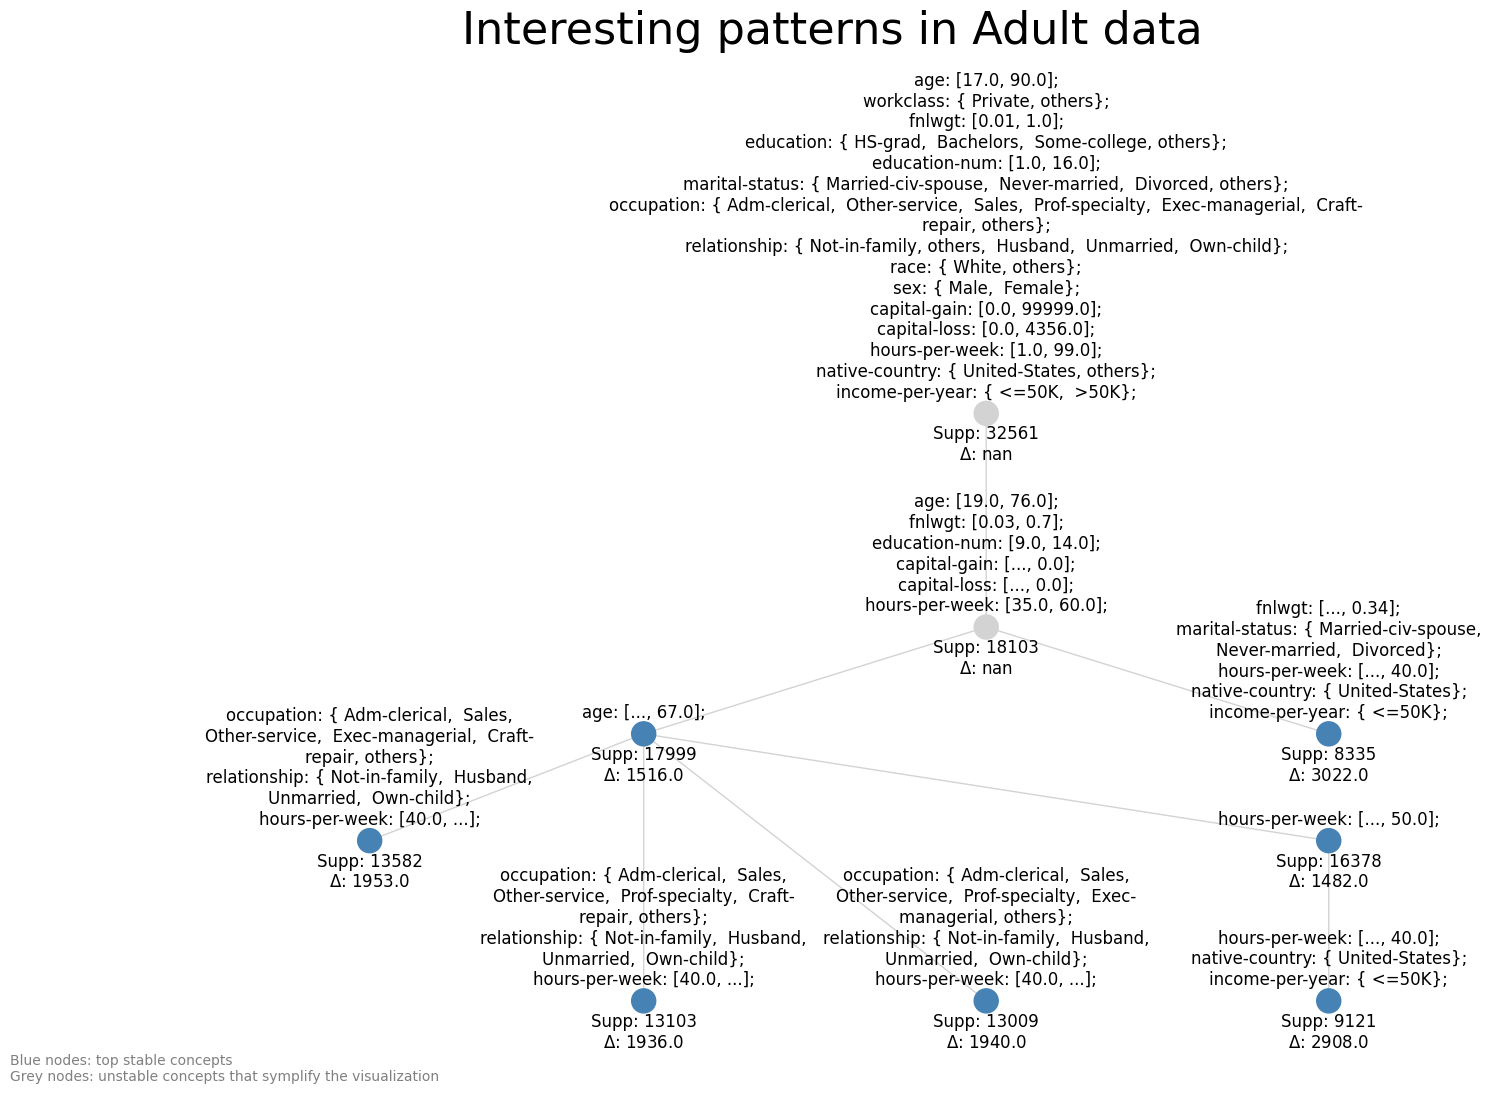

In [45]:
fig, ax = plt.subplots(figsize=(15,11))

node_color = ['steelblue' if delta != 'None' else 'lightgray' for delta in best_patterns_upd['delta_measure'].fillna('None')]
ax.text(-0.95, -1.1, f"Blue nodes: top stable concepts\nGrey nodes: unstable concepts that symplify the visualization", color='grey')

viz.draw_poset(
    poset, ax=ax,
    node_color = node_color,
     node_label_func = node_label_func_adult_upd
)
ax.set_title('Interesting patterns in Adult data', size=32)


plt.ylim(-1, 2.75)
plt.xlim(-0.8, 0.5)
fig.tight_layout()
fig.subplots_adjust()
fig.savefig('IntPatterns_Tabular.pdf')
plt.show()

Finally, we can also represent the tabular intents in the form of a datatable. That can be usefull for some applications and analyses.

In [46]:
intents_df = pd.DataFrame(best_patterns['intents'].tolist(), columns=df.columns)
intents_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-per-year
0,"(19.0, 67.0)","( Private, others)","(0.03, 0.7)","( HS-grad, Bachelors, Some-college, others)","(9.0, 14.0)","( Married-civ-spouse, Never-married, Divorce...","( Adm-clerical, Sales, Other-service, Prof-...","( Not-in-family, others, Husband, Unmarried,...","( White, others)","( Male, Female)","(0.0, 0.0)","(0.0, 0.0)","(35.0, 60.0)","( United-States, others)","( <=50K, >50K)"
1,"(19.0, 67.0)","( Private, others)","(0.03, 0.7)","( HS-grad, Bachelors, Some-college, others)","(9.0, 14.0)","( Married-civ-spouse, Never-married, Divorce...","( Adm-clerical, Sales, Other-service, Exec-...","( Not-in-family, Husband, Unmarried, Own-ch...","( White, others)","( Male, Female)","(0.0, 0.0)","(0.0, 0.0)","(40.0, 60.0)","( United-States, others)","( <=50K, >50K)"
2,"(19.0, 67.0)","( Private, others)","(0.03, 0.7)","( HS-grad, Bachelors, Some-college, others)","(9.0, 14.0)","( Married-civ-spouse, Never-married, Divorce...","( Adm-clerical, Sales, Other-service, Prof-...","( Not-in-family, others, Husband, Unmarried,...","( White, others)","( Male, Female)","(0.0, 0.0)","(0.0, 0.0)","(35.0, 40.0)",( United-States),( <=50K)
3,"(19.0, 67.0)","( Private, others)","(0.03, 0.7)","( HS-grad, Bachelors, Some-college, others)","(9.0, 14.0)","( Married-civ-spouse, Never-married, Divorce...","( Adm-clerical, Sales, Other-service, Prof-...","( Not-in-family, Husband, Unmarried, Own-ch...","( White, others)","( Male, Female)","(0.0, 0.0)","(0.0, 0.0)","(40.0, 60.0)","( United-States, others)","( <=50K, >50K)"
4,"(19.0, 67.0)","( Private, others)","(0.03, 0.7)","( HS-grad, Bachelors, Some-college, others)","(9.0, 14.0)","( Married-civ-spouse, Never-married, Divorce...","( Adm-clerical, Sales, Other-service, Prof-...","( Not-in-family, Husband, Unmarried, Own-ch...","( White, others)","( Male, Female)","(0.0, 0.0)","(0.0, 0.0)","(40.0, 60.0)","( United-States, others)","( <=50K, >50K)"
5,"(19.0, 76.0)","( Private, others)","(0.03, 0.34)","( HS-grad, Bachelors, Some-college, others)","(9.0, 14.0)","( Married-civ-spouse, Never-married, Divorced)","( Adm-clerical, Other-service, Sales, Prof-...","( Not-in-family, others, Husband, Unmarried,...","( White, others)","( Male, Female)","(0.0, 0.0)","(0.0, 0.0)","(35.0, 40.0)",( United-States),( <=50K)
6,"(19.0, 67.0)","( Private, others)","(0.03, 0.7)","( HS-grad, Bachelors, Some-college, others)","(9.0, 14.0)","( Married-civ-spouse, Never-married, Divorce...","( Adm-clerical, Sales, Other-service, Prof-...","( Not-in-family, others, Husband, Unmarried,...","( White, others)","( Male, Female)","(0.0, 0.0)","(0.0, 0.0)","(35.0, 50.0)","( United-States, others)","( <=50K, >50K)"


# Part 3. Stable Ngrams concepts

Another type of complex data one can face is the textual data. With pattern structures we can apply FCA techniques to find interesting textual patterns.

For example, we can find stable ngrams in the first Harry Potter book.

## 3.1 Load and preprocess the data

First, let us load and preprocess the data

In [47]:
base_url = 'https://raw.githubusercontent.com/neelk07/neelkothari/master/blog/static/data/text/'
book_names = [
    "Harry Potter and the Sorcerer's Stone",
    'Harry Potter and the Chamber of Secrets',
    'Harry Potter and the Prisoner of Azkaban',
    'Harry Potter and the Goblet of Fire',
    'Harry Potter and the Order of the Phoenix',
    'Harry Potter and the Half-Blood Prince',
    'Harry Potter and the Deathly Hallows',
]

books_txt = []
for bn in book_names:
  data = requests.get(f"{base_url}{bn.replace(' ', '%20')}.txt")
  books_txt.append(data.content.decode())

Here we split the data to sentences, because we want to analyse the text sentence by sentence. Depending on the task, we can split the data into the pairs of consequitive sentences, or we can split the text by pages, or by chapters.

In [48]:
sentences = []
book_numbers = []
for book_number, book_txt in enumerate(books_txt, start=1):
    book_sentences = sent_tokenize(book_txt)
    sentences.extend(book_sentences)
    book_numbers.extend([book_number] * len(book_sentences))

assert len(sentences) == len(book_numbers)

Here we split the punctuation signs to make them the tokens on their own.

In [49]:
PUNCTUATION = {'.', ',', '!', '?', '”', '“'}

for p in PUNCTUATION:
    sentences = [s.replace(p, f" {p} ").strip().strip(p) for s in sentences]
sentences = [re.sub(r"\s+", " ", s).strip().lower() for s in sentences]

Finally, let us select the sentences from the first book.

In [50]:
sentences_book1 = [s for s, n in zip(sentences, book_numbers) if n == 1]

len(sentences_book1), len(sentences)

(4938, 61347)

## 3.2 Introducing Ngram pattern structures

With the ngrams (sequences of words) we can easily define when one ngram is less precise than another. For example, ngram "Harry reads" is less precise than "Harry reads a book":
$$\text{"Harry reads"} \sqsubseteq \text{"Harry reads a book"},$$ as the former one also covers the sentences when Harry reads a paper, a spell, or even "two books".

However, two sentences can have many maximal incomparable ngrams. For example:
$$\text{"Harry reads a book"} \sqcap \text{"Harry closed a book"} = \{\text{"Harry", "a book"}\}$$.
Here, we cannot say that ngram "Harry" is more precise than ngram "a book". And we cannot say the contrary.

So, in ngram pattern structure $(D, \sqcap)$ the space $D$ is the space of subsets of incomparable ngrams, and $\sqcap$ outputs the most precise common ngrams found in two given sets of ngrams.

_The formal mathematical definition of an Ngram pattern structure takes a lot of space. So we omit it here._

In [51]:
ps = PS.NgramPS()
data_book1 = list(ps.preprocess_data(sentences_book1))

In [52]:
sentences_book1[:2]

['chapter 1 the boy who lived mr . and mrs . dursley , of number four , privet drive , were proud to say that they were perfectly normal , thank you very much',
 'they were the last people you’d expect to be involved in anything strange or mysterious , because they just didn’t hold with such nonsense']

In [53]:
ps.intent(data_book1[:2])

frozenset({(',',), ('the',), ('they', 'were'), ('to',)})

Here we show the first two sentences from the first Harry Potter book. And we show their maximal common ngrams. That is, for example, ngram "they were" is contained in both the first and the second sentence, and there is no ngram more precise than "they were" that also lies in these sentences.

## 3.3 Mining stable ngram concepts

When binarizing the ngram pattern structure, `paspailleur` iterates over all possible ngrams whose support is higher than `min_support` value.

In [54]:
bin_attrs_iterator = ps.iter_bin_attributes(data_book1, min_support=0.005)
for i in range(900):
    next(bin_attrs_iterator)

bin_attr, extent = next(bin_attrs_iterator)
print(f'Binary attribute: {bin_attr}')
print(f'Extent: {extent}')

Binary attribute: ('i', 'think')
Extent: frozenbitarray('0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000

Theoretically, there can be infinitely many ngrams in the data. But, in practice, this number is not that high.

In [55]:
ps.n_bin_attributes(data_book1, min_support=0.005)

993

There are 993 possible ngrams with support higher than 0.5%. However, some of these ngrams are just sequences of stop words. For example: "and", "the", "and the", etc. Such stopwords are frequent by definition and also very stable. So it is better to filter them out before running the Sofia algorithm.

If an ngram contains both stop words and non-stop words, we let it pass to the algorithm. For example, ngram "the ministy of magic" consists of 2 stop words ("the", "of"), but it can be interesting for the analysis.

In [56]:
STOPWORDS = set(stopwords.words('english')) | PUNCTUATION
attr_extents = [
    ext for descr, ext in ps.iter_bin_attributes(data_book1, min_support=0.005)
    if not (set(descr) <= STOPWORDS)  # Do not consider ngrams, that consist only of stop words
]

stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_sofia(
    attr_extents, n_stable_extents=1000,
    use_tqdm=True, n_attributes=len(attr_extents)
)
stable_extents = sorted(stable_extents, key=lambda ext: ext.count())
print(len(stable_extents))

  0%|          | 0/604 [00:00<?, ?it/s]

1000


Now we reconstruct the intents from the computed stable extents. And we put them in a pandas.DataFrame.

In [57]:
stable_extents_isets = list(csp.base_functions.bas2isets(stable_extents))

stable_intents = [ps.intent(data_book1, extent) for extent in tqdm(stable_extents_isets)]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [58]:
patterns_df = pd.DataFrame()
patterns_df['extents'] = stable_extents_isets
patterns_df['intents'] = stable_intents
patterns_df['intents_verb'] = [[' '.join(ngram) for ngram in intent] for intent in stable_intents]
patterns_df['support'] = [len(extent) for extent in stable_extents_isets]
patterns_df['delta_measure'] = list(csp.indices.delta_stability_index(stable_extents))

Again, the pipeline to compute the stable ngram concepts is very similar to the pipeline of computing the stable binary concepts. The only difference is the preprocessing of data (like dealing with punctuation and stopwords).

## 3.4 Selecting the most interesting concepts

Now we can again compute the interestingness of concepts as the product of their supports and their delta-measures.

In [59]:
patterns_df['interestingness'] = patterns_df['support'] * patterns_df['delta_measure']

## 3.5 Visualizing the most interesting concepts

Let us visualize the most interesting ngram concepts

In [60]:
best_patterns = patterns_df.sort_values('interestingness', ascending=False).head(20).reset_index(drop=True)
best_patterns.head()

,extents,intents,intents_verb,support,delta_measure,interestingness
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",(),[],4938,3789,18710082
1,"(2051, 4102, 4106, 4107, 4109, 2062, 4110, 411...","((harry,))",[harry],1149,931,1069719
2,"(2049, 2065, 18, 19, 4118, 4120, 4121, 26, 412...","((—,))",[—],597,404,241188
3,"(2048, 4097, 2053, 2056, 4112, 4113, 2067, 26,...","((said,))",[said],764,213,162732
4,"(2048, 2053, 4112, 4113, 2074, 2078, 4126, 412...","((,, ”, said))","[, ” said]",415,277,114955


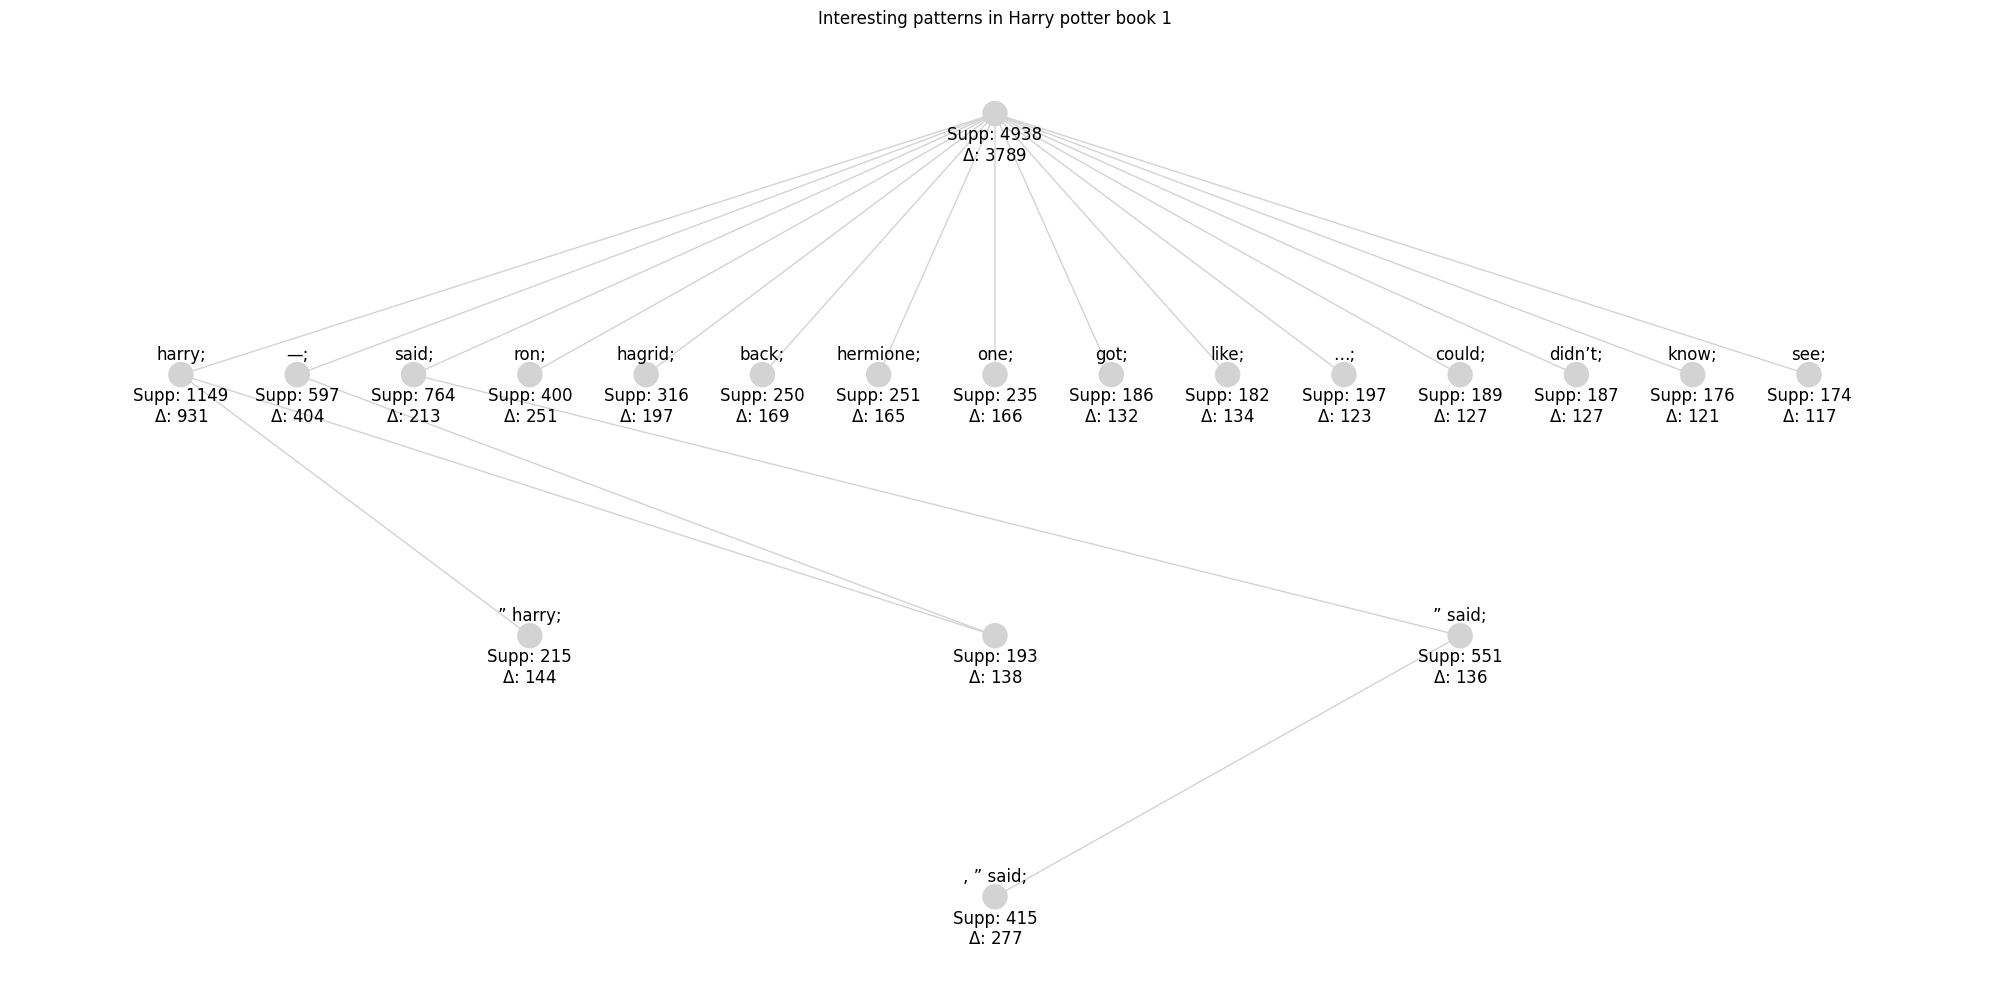

In [61]:
poset = POSet(best_patterns['extents'])

fig, ax = plt.subplots(figsize=(20,10))

node_label_func_potter = lambda el_i, P: concept_label_func(
    el_i, P, best_patterns,
    intent_to_strings_func = intent_to_strings_ngram,
)

viz = LineVizNx()
viz.draw_poset(
    poset, ax=ax,
    node_label_func = node_label_func_potter
)
plt.title('Interesting patterns in Harry potter book 1')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

Now we slightly update the nodes positions

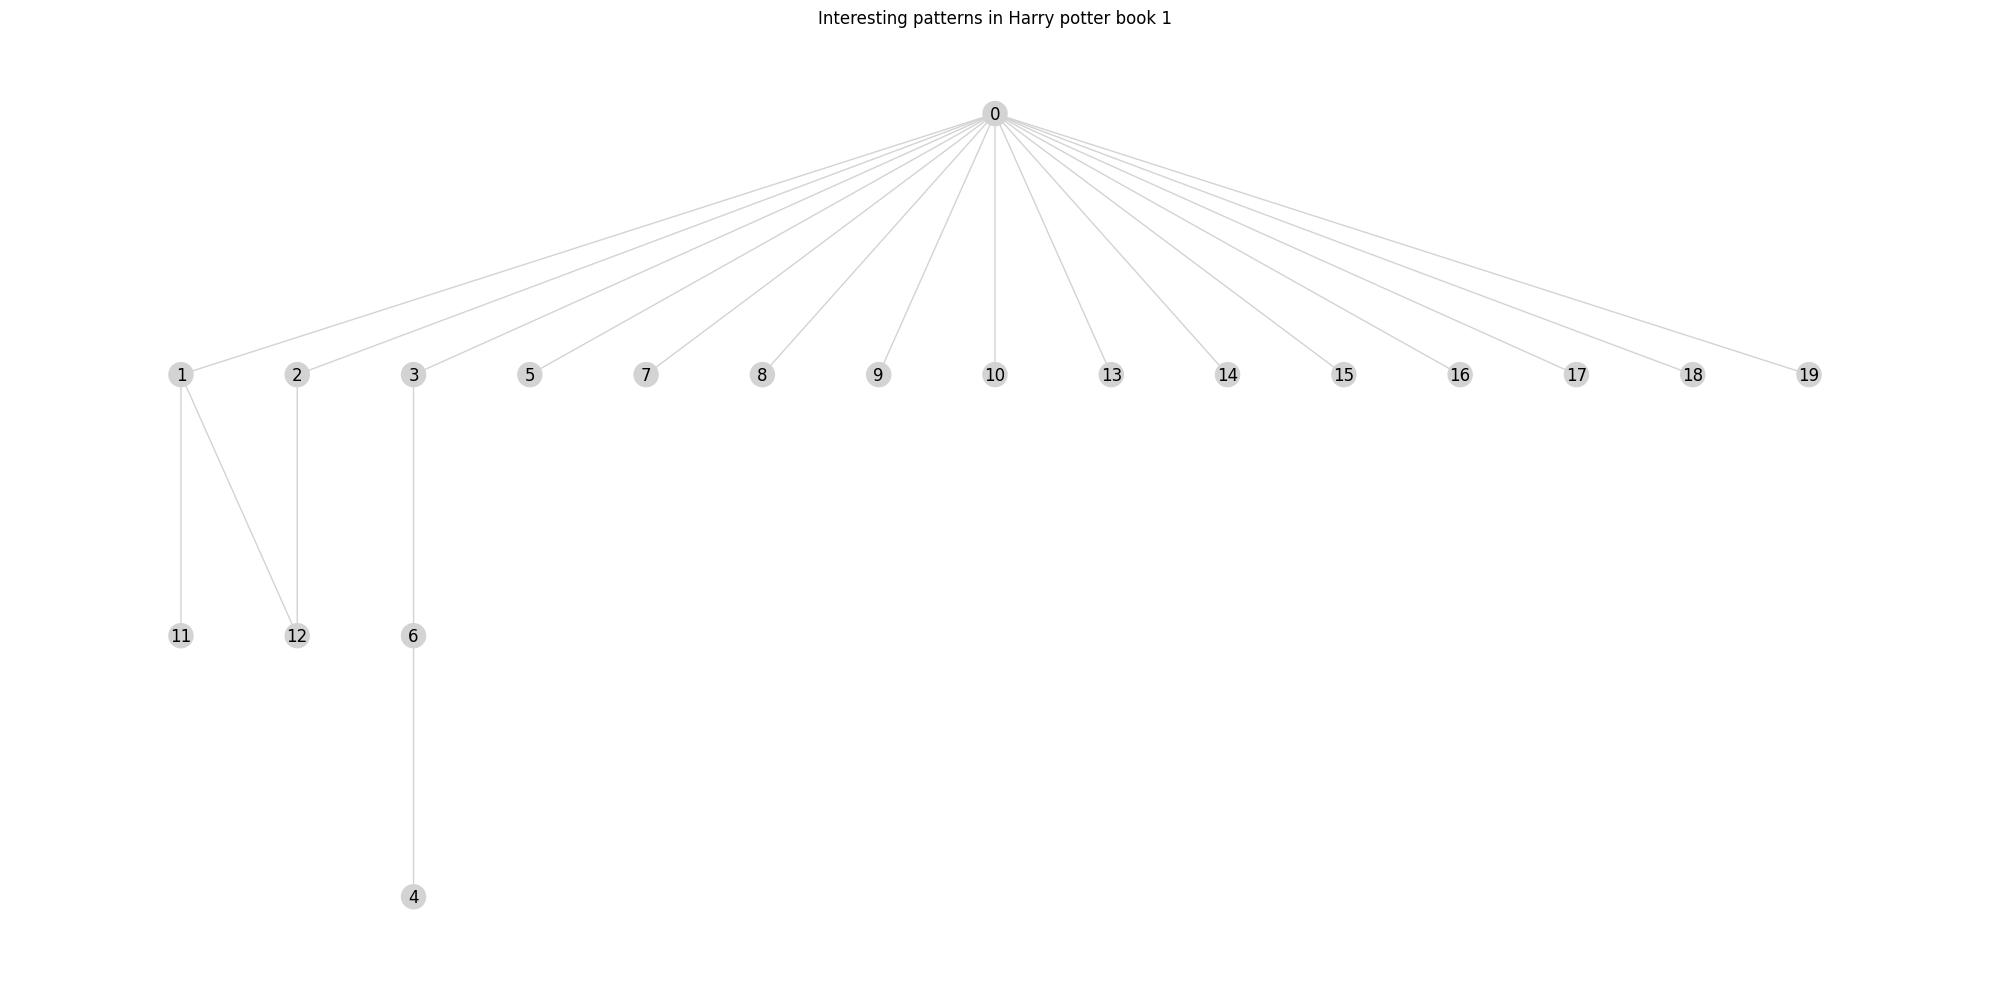

In [62]:
poset = POSet(best_patterns['extents'])

fig, ax = plt.subplots(figsize=(20,10))

viz = LineVizNx()
viz.init_mover_per_poset(poset)
posx = list(viz.mover.posx)
for i in [11, 6, 4]:
  parents = poset.parents(i)
  posx[i] = sum(posx[parent_i] for parent_i in parents)/len(parents)
posx[12] = posx[2]
viz.mover.posx = posx

viz.draw_poset(
    poset, ax=ax,
    flg_node_indices=True
)
plt.title('Interesting patterns in Harry potter book 1')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

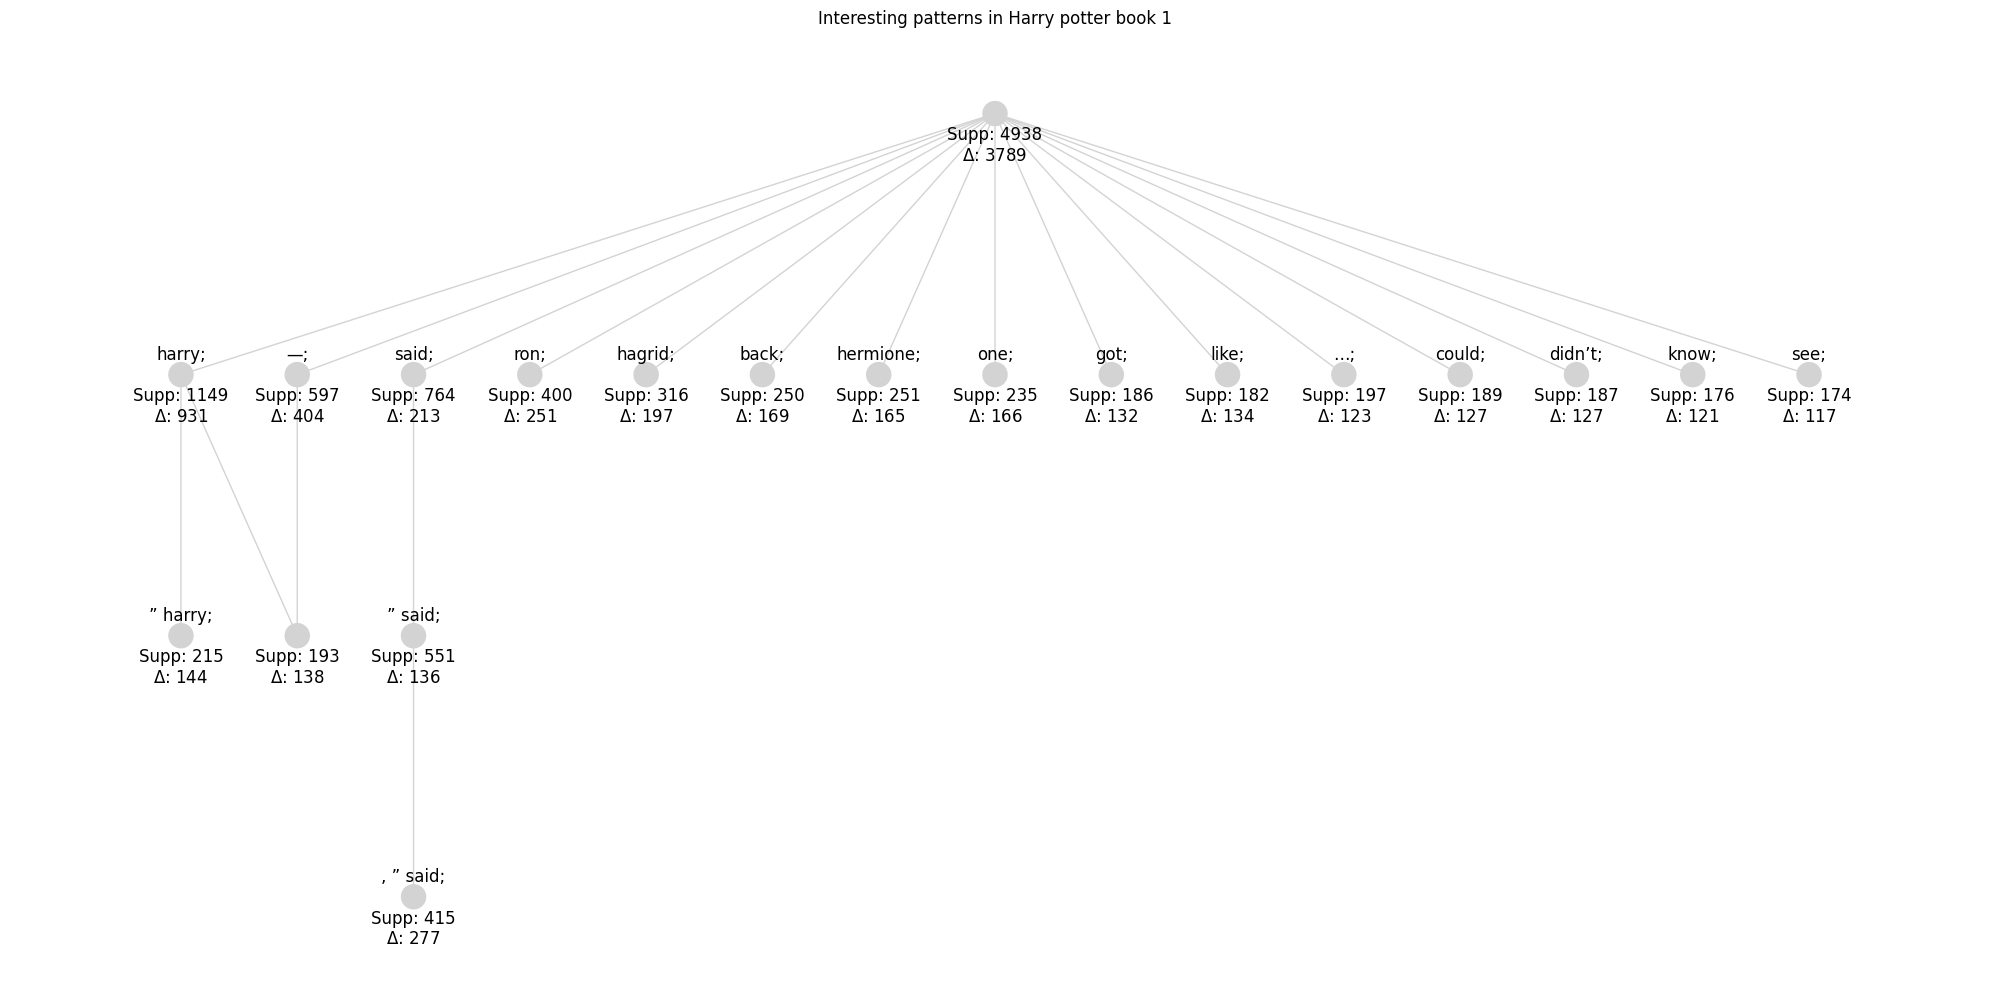

In [63]:
fig, ax = plt.subplots(figsize=(20,10))

viz.draw_poset(
    poset, ax=ax,
    node_label_func = node_label_func_potter,
)
plt.title('Interesting patterns in Harry potter book 1')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('IntPatterns_Ngrams.pdf')
plt.show()

## 3.6* Concepts as classifiers

Another way to measure the interestingness of a set of descriptions is to see how good they classify something. For example, when reading a random sentence from the Harry Potter books, what set of ngrams will let us know that the sentence we read belongs to the first book.

So first, let us compute the support of every stable description from the first book w.r.t. all the sentences from all the Harry Potter books.

In [64]:
data = list(ps.preprocess_data(sentences))
patterns_df['support_all'] = [len(list(ps.extent(data, intent))) for intent in tqdm(patterns_df['intents'])]

  0%|          | 0/1000 [00:00<?, ?it/s]

Every description can be considered as a binary classifier of the form: $$\text{"if all ngrams from the description are in the sentence} \to \text{this sentence belongs to the first book"}$$.

Speaking in machine learning terms, the description support w.r.t. the first book is the number of TruePositive predictions, and the description support w.r.t. all the books is the amound of all Positive predictions (i.e. TruePositives + FalsePositives).

Then, the relation of these two supports gives us the precision of the classification.

In [65]:
patterns_df['precision'] = patterns_df['support']/patterns_df['support_all']

In [66]:
best_patterns = patterns_df.sort_values('precision', ascending=False).head(20).reset_index(drop=True)
best_patterns.head(10)

,extents,intents,intents_verb,support,delta_measure,interestingness,support_all,precision
0,"(1088, 1089, 1377, 2688, 4740, 1093, 2983, 276...","((quirrell,), (professor,))","[quirrell, professor]",17,17,289,18,0.944444
1,"(2, 130, 13, 15, 16, 19, 276, 23, 25, 27, 32, ...","((mr, ., dursley))",[mr . dursley],30,30,900,32,0.937500
2,"(0, 2, 130, 4, 8, 12, 13, 15, 16, 19, 276, 23,...","((., dursley))",[. dursley],42,12,504,45,0.933333
3,"(4608, 4612, 4614, 4615, 4621, 4627, 4633, 463...","((quirrell,))",[quirrell],79,61,4819,87,0.908046
4,"(0, 4, 102, 8, 106, 12, 13, 110, 15, 111, 113,...","((mrs, ., dursley))",[mrs . dursley],16,16,256,18,0.888889
5,"(4704, 4706, 4707, 4580, 4709, 3878, 4711, 474...","((—,), (quirrell,))","[—, quirrell]",15,15,225,17,0.882353
6,"(2688, 1089, 3874, 4706, 4707, 1093, 3878, 458...","((harry,), (quirrell,))","[harry, quirrell]",18,18,324,21,0.857143
7,"(328, 491, 555, 716, 369, 274, 404, 949, 1911,...","((dudley,), (one,))","[dudley, one]",12,12,144,18,0.666667
8,"(2689, 2820, 2695, 2698, 2702, 2721, 2725, 273...","((troll,))",[troll],29,29,841,44,0.659091
9,"(771, 772, 4860, 3590, 892, 787, 804, 810, 363...","((yer,), (yeh,))","[yer, yeh]",24,24,576,39,0.615385


Let us add the most general pattern to the list of the most precise descriptions (just to make the diagram more lattice-looking).

In [67]:
if (best_patterns['support']<len(sentences_book1)).all():
  new_extent = frozenset(range(len(sentences_book1)))
  new_intent = ps.intent(data_book1, new_extent)
  best_patterns.loc[len(best_patterns)] = {'extents': new_extent, 'intents': new_intent, 'intents_verb': [' '.join(ngram) for ngram in new_intent], 'support': len(new_extent), 'support_all': len(sentences)}
  best_patterns['precision'] = best_patterns['support']/best_patterns['support_all']

And now we can visualize the most precise concepts that help us identify the sentences from the first book.

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


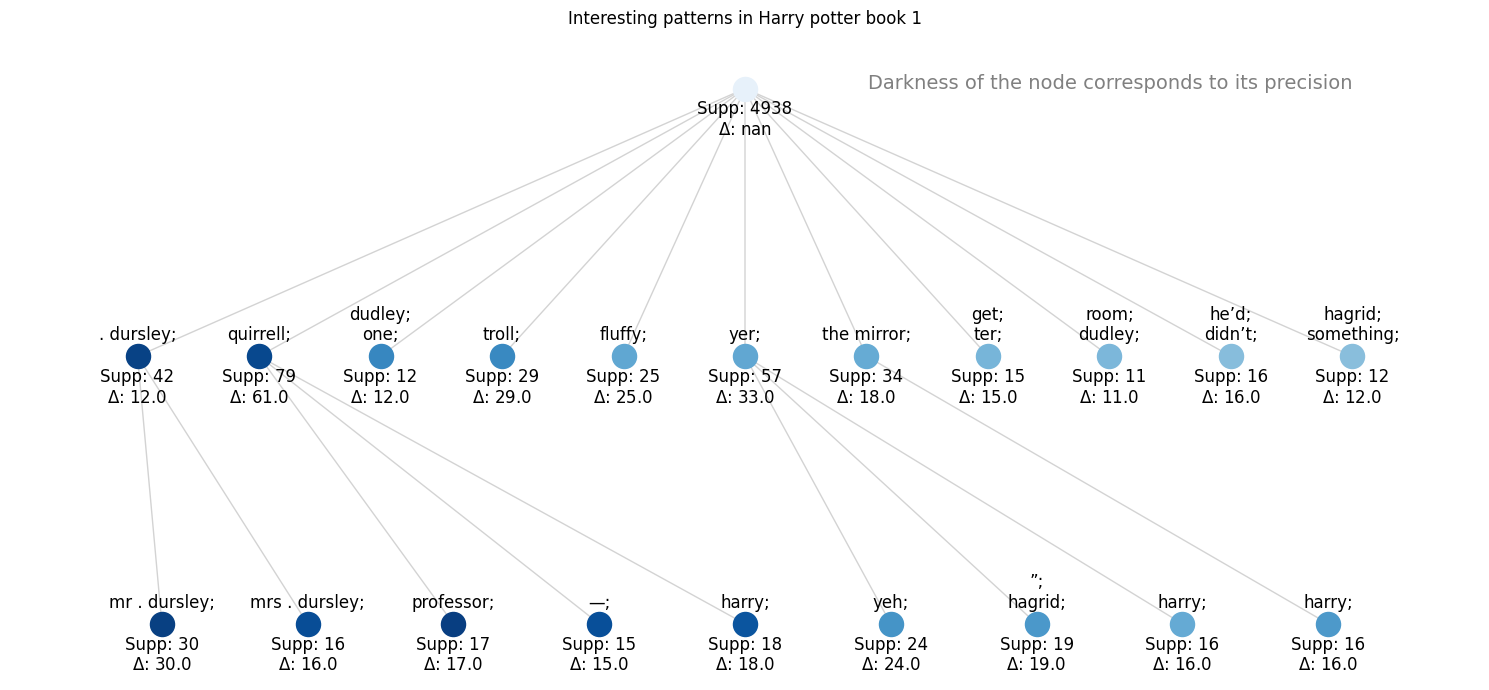

In [68]:
poset = POSet(best_patterns['extents'])

cmap = plt.colormaps.get_cmap('Blues')
node_color = [cmap(x) for x in best_patterns['precision'].tolist()]
assert len(poset)==len(node_color)

fig, ax = plt.subplots(figsize=(15,7))

node_label_func_potter_clf = lambda el_i, P: concept_label_func(
    el_i, P, best_patterns, intent_to_strings_ngram
)
viz = LineVizNx()
viz.draw_poset(
    poset, ax=ax,
    node_label_func = node_label_func_potter_clf,
    node_color=node_color, cmap_min=0, cmap_max=1
)
plt.title('Interesting patterns in Harry potter book 1')

plt.text(max(viz.mover.posx), max(viz.mover.posy), 'Darkness of the node corresponds to its precision', size=14, ha='right', color='gray')

plt.tight_layout()
plt.subplots_adjust()
plt.savefig('IntPatterns_NgramsPrecise.pdf')
plt.show()

Also, since we work with ngrams, we can put them into a WordCloud. Or, more precisely, we can put them into a SetOfNgrams Cloud.

In [69]:
best_patterns = patterns_df[patterns_df['precision']>1/7]
best_patterns['intents_str'] = ['; '.join(intent) for intent in best_patterns['intents_verb']]
best_intents_freqs = best_patterns.groupby('intents_str')['support'].max().to_dict()

# We use `wordcloud` package to generate the wordcloud
wordcloud = WordCloud(width=2100, height=1300, min_font_size=4, collocations=False, stopwords=set(), repeat=False, random_state=42, background_color='white')
wordcloud = wordcloud.generate_from_frequencies({'<'+k.replace('\n', ' & ')+'>': v for k, v in best_intents_freqs.items()})

<ipython-input-69-db23b0ef7722>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_patterns['intents_str'] = ['; '.join(intent) for intent in best_patterns['intents_verb']]


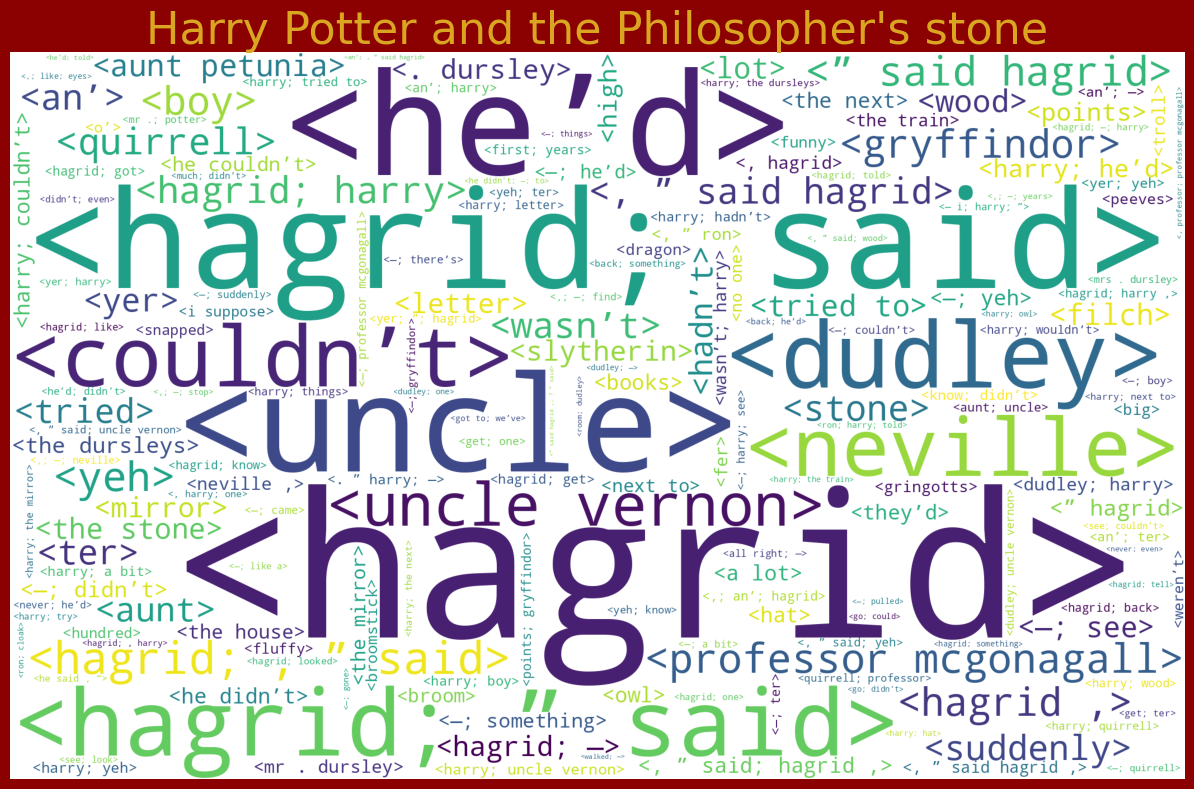

In [70]:
fig, ax = plt.subplots(figsize=(14,8), facecolor='darkred')

ax.imshow(wordcloud)

ax.set_title("Harry Potter and the Philosopher's stone", size=32, color='goldenrod')
ax.axis('off')
fig.subplots_adjust()
fig.tight_layout()

fig.savefig('IntPatterns_NgramsCloud.pdf')
plt.show()

# Part 4. Conclusion

In this tutorial we used `paspailleur` and pattern structures to find stable concepts in a binary dataset, a tabular dataset, and a textual dataset. Note that the pipelines of finding these concepts are almost the same for every type of data. They only differ in the preprocessing (and simplification) of the data and in the process of transforming complex patterns into textual descriptions.

Note that `paspailleur` can also process the data which is both tabular and textual. For example, when one column shows the textual review of some product and the other column shows the number of sold product. Here, the first column can be processed via `NgramPS`, the second column can be processed via `IntervalPS`, and they can be merged together via `CartesianPS`.


For now it takes some time to set up a nice line diagram visualization of the stable concepts. But I (Egor Dudyrev) will work on it, and I will try to make more user friendly. Also, I have some plans to improve the processing of numeric and categorical data.